In [1]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

In [66]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedShuffleSplit

from sklearn.cross_decomposition import PLSRegression
from sklearn.svm import SVR
from sklearn.model_selection import cross_val_score
from sklearn.metrics import r2_score
from sklearn.decomposition import PCA
from scipy.signal import savgol_filter
from sklearn.metrics import mean_squared_error

from sklearn.svm import SVR
from sklearn.model_selection import GridSearchCV
import seaborn as sns
sns.set_style('darkgrid')

from sklearn.ensemble import RandomForestRegressor

# Preprocess

In [4]:
#first we'll start with the NIRONE2-0 absorbance
pathToData = "./../../preprocessed/path/1mm/sensor/NIRONE2-5/NIRONE2-5_absorbance_dark_1mm.csv"
header=0
with open(pathToData, 'r') as f:
    lines = f.readlines()
for i in range(len(lines)):
    line = lines[i]
    if line[0]=="#":
        header = i+1
    if "#metadataColumns" in line:
        meta = line.strip("\n")
    if "#targetColumns" in line:
        targets = line.strip("\n")
df = pd.read_csv(pathToData, header=header)
metaColumns = meta.split(":")[1].split(",")
targetColumns = targets.split(":")[1].split(",")

In [5]:
dataDF = df.drop(metaColumns+targetColumns, axis = 1)
dataDF.head()

2000.0000  2010.0000  2020.0000  2030.0000  2040.0000  2050.0000  \
0   2.361417   2.286458   2.216943   2.136333   2.061994   1.981921   
1   2.446101   2.396062   2.325266   2.240716   2.173877   2.090678   
2   2.447529   2.392996   2.314755   2.241852   2.180385   2.096929   
3   2.447192   2.399139   2.317239   2.253939   2.172327   2.102710   
4   2.448352   2.398119   2.320862   2.247306   2.178990   2.098266   

   2060.0000  2070.0000  2080.0000  2090.0000  ...  2360.0000  2370.0000  \
0   1.906561   1.836162   1.772100   1.705574  ...   1.664042   1.714860   
1   2.025145   1.958179   1.898115   1.829401  ...   1.783383   1.836131   
2   2.026149   1.960946   1.900540   1.831843  ...   1.790273   1.842235   
3   2.033444   1.959363   1.895167   1.834151  ...   1.791173   1.846609   
4   2.032424   1.959263   1.900719   1.834010  ...   1.793378   1.846035   

   2380.0000  2390.0000  2400.0000  2410.0000  2420.0000  2430.0000  \
0   1.767578   1.814649   1.866978   1.896803   1.938043   1.960358   
1   1.891908   1.939211   1.984087   2.016933   2.051217   2.083639   
2   1.889531   1.939729   1.987462   2.022159   2.058170   2.080363   
3   1.892057   1.945131   1.975572   2.025544   2.064578   2.076117   
4   1.894608   1.941808   1.983547   2.032866   2.056144   2.091005   

   2440.0000  2450.0000  
0   1.988988   1.989427  
1   2.101289   2.133568  
2   2.104724   2.125022  
3   2.112304   2.107496  
4   2.113778   2.118158  

[5 rows x 46 columns]

In [6]:
#get the null indices
inds = pd.isnull(dataDF).any(1).to_numpy().nonzero()[0]
print(len(inds))

0


In [7]:
# #drop those null rows
# df = df.drop(df.index[inds])
# #check to see if there are any more null rows
# dataDF = df.drop(metaColumns+targetColumns, axis = 1)
# #get the null indices
# inds = pd.isnull(dataDF).any(1).to_numpy().nonzero()[0]
# print(len(inds))

In [8]:
#get rid of the non-numeric metadata
df = df.drop([col for col in metaColumns if col!='key'], axis = 1)
df.shape

(13560, 55)

In [9]:
#take the mean of the replicates  - there are 113 samples
meanDF = df.groupby('key').mean()
meanDF.shape

(113, 54)

In [10]:
#make sure there are no null values
meanDF.isnull().values.any()

False

# Check for outliers

In [34]:
#Get rid of outliers if any   

meanDF = meanDF.drop(meanDF.index[outlierList])

In [35]:
spectralDF = meanDF.drop(targetColumns,axis=1)
wavelengths = np.array(spectralDF.columns).astype(float)

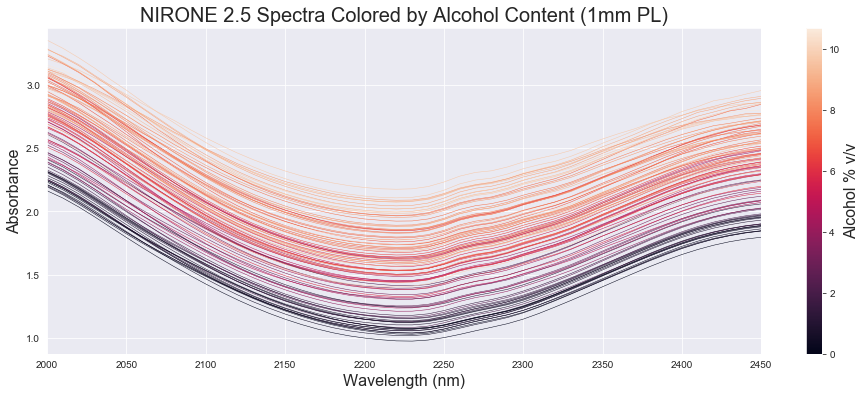

In [36]:
x = wavelengths
y = spectralDF.values
z = meanDF['ALCIR']

ys = [i for i in y] #put into the format for LineCollection

# We need to set the plot limits, they will not autoscale
# fig, ax = plt.subplots(figsize=(8,3)) #for paper
fig, ax = plt.subplots(figsize=(16,6))
ax.set_xlim(np.min(x), np.max(x))
ax.set_ylim(np.min(ys)-.1, np.max(ys)+.1)
# # Make a sequence of x,y pairs
line_segments = LineCollection([np.column_stack([x, y]) for y in ys],
                               array = z,
                               linewidths=0.5,
                               linestyles='solid')

ax.add_collection(line_segments)
axcb = fig.colorbar(line_segments)
axcb.set_label('Alcohol % v/v', fontsize=16)
ax.set_title("NIRONE 2.5 Spectra Colored by Alcohol Content (1mm PL)", fontsize=20)
ax.set_ylabel("Absorbance", fontsize = 16)
ax.set_xlabel("Wavelength (nm)", fontsize = 16)
plt.show()

In [37]:
dataMat = spectralDF.values
scaledDataMat = np.transpose(StandardScaler().fit_transform(np.transpose(dataMat)))
scaledDataMat.shape

(104, 46)

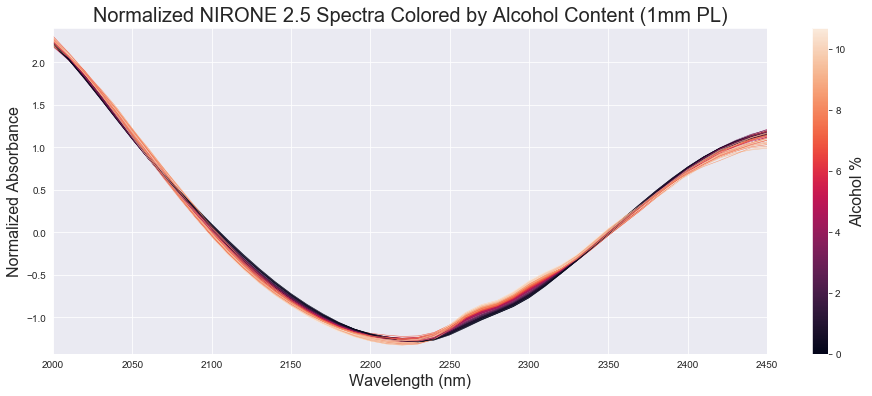

In [38]:
x = wavelengths
y = scaledDataMat
z = meanDF['ALCIR']

ys = [i for i in y] #put into the format for LineCollection

# We need to set the plot limits, they will not autoscale
# fig, ax = plt.subplots(figsize=(8,3)) #for paper
fig, ax = plt.subplots(figsize=(16,6))
ax.set_xlim(np.min(x), np.max(x))
ax.set_ylim(np.min(ys)-.1, np.max(ys)+.1)
# # Make a sequence of x,y pairs
line_segments = LineCollection([np.column_stack([x, y]) for y in ys],
                               array = z,
                               linewidths=0.5,
                               linestyles='solid')

ax.add_collection(line_segments)
axcb = fig.colorbar(line_segments)
axcb.set_label('Alcohol %', fontsize=16)
ax.set_title("Normalized NIRONE 2.5 Spectra Colored by Alcohol Content (1mm PL)", fontsize=20)
ax.set_ylabel("Normalized Absorbance", fontsize = 16)
ax.set_xlabel("Wavelength (nm)", fontsize = 16)
plt.show()

In [39]:
#PCA
model = PCA(n_components = 10)
X_PCA = model.fit(scaledDataMat)

explainedVariance = X_PCA.explained_variance_ratio_
explainedVariance

array([0.6510287 , 0.22899776, 0.07142757, 0.03409582, 0.00626237,
       0.00153936, 0.00102398, 0.0008632 , 0.00074381, 0.00065206])

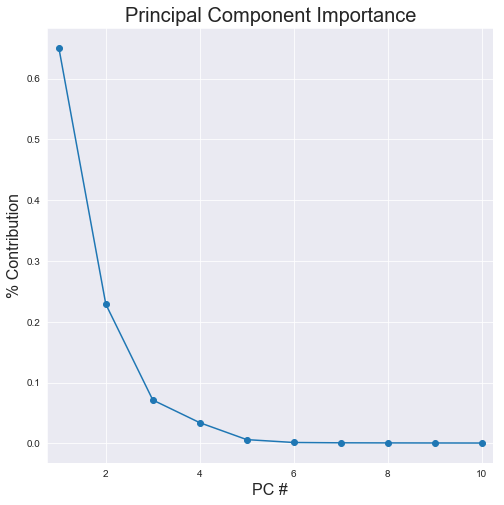

In [40]:
fig, ax = plt.subplots(figsize = (8,8))
x = np.linspace(1,len(explainedVariance),len(explainedVariance))
ax.plot(x,explainedVariance, marker = 'o')
ax.set_xlim([0.75,10.25])
plt.title("Principal Component Importance", fontsize = 20);
ax.set_ylabel("% Contribution", fontsize = 16);
ax.set_xlabel("PC #", fontsize = 16);

In [41]:
PCA_MAT = model.fit_transform(scaledDataMat)
# PCA_MAT = model.fit_transform(dxMAT)
PCA_MAT.shape

(104, 10)

In [23]:
# #detect outliers
# outlierList = []
# for i in range(PCA_MAT.shape[0]):
#     x = PCA_MAT[i,0]
#     if x>1.5:
#         print(i)
#         outlierList.append(i)

20
21
22
23
24
25
26
27


In [33]:
# #detect outliers
# outlierList = []
# for i in range(PCA_MAT.shape[0]):
#     x = PCA_MAT[i,1]
#     if x>0.5:
#         print(i)
#         outlierList.append(i)

54


(104,)


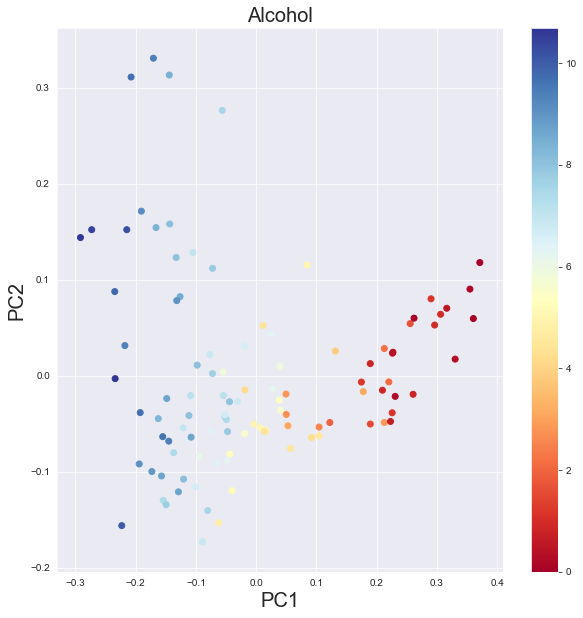

In [42]:
x = PCA_MAT[:,0]
y = PCA_MAT[:,1]


col = meanDF['ALCIR']
print(col.shape)
fig, ax = plt.subplots(figsize = (10,10))
cm = plt.cm.get_cmap('RdYlBu')
sc = ax.scatter(x,y,c=col,vmin = col.min(),vmax = col.max(), cmap = cm)
ax.set_xlabel("PC1", fontsize=20)
ax.set_ylabel("PC2", fontsize = 20)
plt.colorbar(sc)
plt.title("Alcohol",fontsize =20)
plt.show()

In [43]:
dxMAT = savgol_filter(spectralDF.values, window_length=25,polyorder=3,deriv=1)

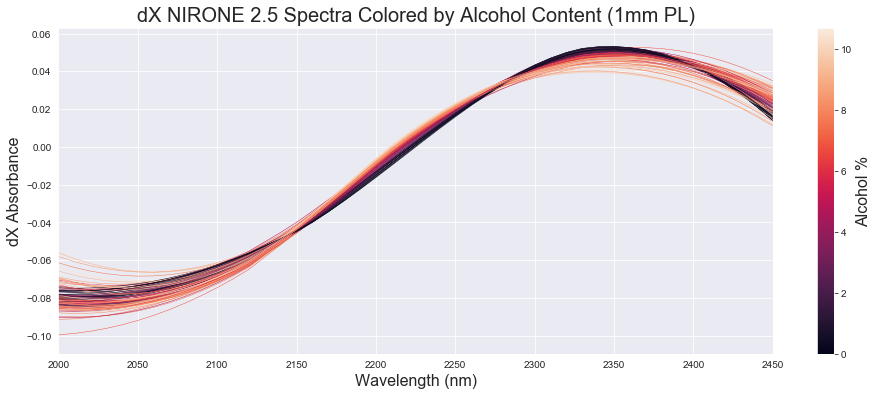

In [44]:
x = wavelengths
y = dxMAT
z = meanDF['ALCIR']

ys = [i for i in y] #put into the format for LineCollection

# We need to set the plot limits, they will not autoscale
# fig, ax = plt.subplots(figsize=(8,3)) #for paper
fig, ax = plt.subplots(figsize=(16,6))
ax.set_xlim(np.min(x), np.max(x))
ax.set_ylim(np.min(ys)-.01, np.max(ys)+.01)
# # Make a sequence of x,y pairs
line_segments = LineCollection([np.column_stack([x, y]) for y in ys],
                               array = z,
                               linewidths=0.5,
                               linestyles='solid')

ax.add_collection(line_segments)
axcb = fig.colorbar(line_segments)
axcb.set_label('Alcohol %', fontsize=16)
ax.set_title("dX NIRONE 2.5 Spectra Colored by Alcohol Content (1mm PL)", fontsize=20)
ax.set_ylabel("dX Absorbance", fontsize = 16)
ax.set_xlabel("Wavelength (nm)", fontsize = 16)
plt.show()

# Removed outliers are at indices: 
20
21
22
23
24
25
26
27
 
 and 54

# Here we start with the analysis for alcohol

Text(0.5, 1.0, 'Overall Distribution for Alcohol')

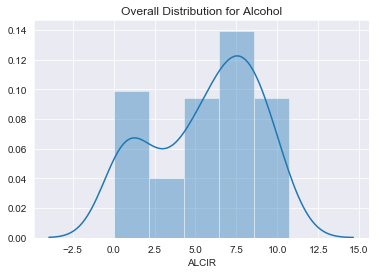

In [45]:
#check out the distribution for Alcohol
sns.distplot(meanDF['ALCIR'])
plt.title("Overall Distribution for Alcohol")

In [46]:
#Divide into categories
meanDF['ALCIR_categories'] = np.ceil(meanDF['ALCIR']/3)
meanDF.ALCIR_categories.value_counts().sort_index()

0.0     3
1.0    24
2.0    21
3.0    41
4.0    15
Name: ALCIR_categories, dtype: int64

In [49]:
#combine categories
meanDF['ALCIR_categories'].where(meanDF['ALCIR_categories']>0,1.0, inplace=True)
meanDF.ALCIR_categories.value_counts().sort_index()

1.0    27
2.0    21
3.0    41
4.0    15
Name: ALCIR_categories, dtype: int64

In [50]:
split = StratifiedShuffleSplit(n_splits=1,test_size=0.2, random_state=42)

for train_index, test_index in split.split(meanDF,meanDF["ALCIR_categories"]):
    trainDF = meanDF.reset_index().loc[train_index]
    testDF = meanDF.reset_index().loc[test_index]

#get rid of the *_categories
meanDF = meanDF.drop("ALCIR_categories", axis=1)
trainDF = trainDF.drop("ALCIR_categories", axis=1)
testDF = testDF.drop("ALCIR_categories", axis=1)

In [51]:
trainDF = trainDF.reset_index(drop=True)
testDF = testDF.reset_index(drop=True)

In [52]:
trainDF.shape,testDF.shape

((83, 55), (21, 55))

Text(0.5, 1.0, 'Training Distribution for Alcohol')

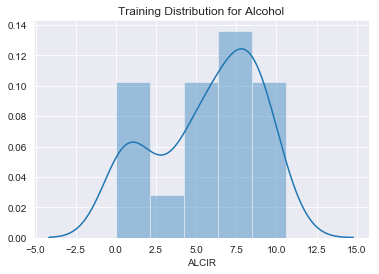

In [53]:
#check out the distribution for Alcohol
sns.distplot(trainDF['ALCIR'])
plt.title("Training Distribution for Alcohol")

Text(0.5, 1.0, 'Testing Distribution for Alcohol')

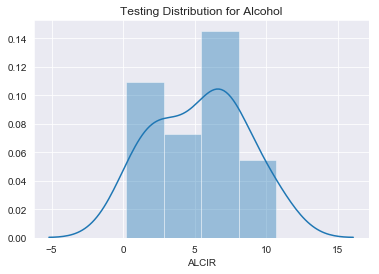

In [54]:
#check out the distribution for Alchohol
sns.distplot(testDF['ALCIR'])
plt.title("Testing Distribution for Alcohol")

In [55]:
#perform necessary preprocessing on the data
dropColumns = targetColumns + ['key']
trainSpectra = trainDF.drop(dropColumns,axis=1)
testSpectra = testDF.drop(dropColumns,axis=1)
print(trainSpectra.shape,testSpectra.shape)

#scale the data
scaledTrainSpectra = np.transpose(StandardScaler().fit_transform(np.transpose(trainSpectra.values)))
scaledTestSpectra = np.transpose(StandardScaler().fit_transform(np.transpose(testSpectra.values)))

#derivative of the data
dXTrainSpectra = savgol_filter(trainSpectra.values, window_length=25, polyorder=3,deriv=1)
dXTestSpectra = savgol_filter(testSpectra.values, window_length=25, polyorder=3, deriv=1)

ddXTrainSpectra = savgol_filter(trainSpectra.values, window_length=25, polyorder=3,deriv=2)
ddXTestSpectra = savgol_filter(testSpectra.values, window_length=25, polyorder=3, deriv=2)

(83, 46) (21, 46)


In [56]:
print(dropColumns)

['ALCIR', 'GFZ', 'VAZ', 'LAZ', 'MAZ', 'TEMPTK', 'YSTV%', 'YSTC', 'key']


# Visualize the training and testing sets

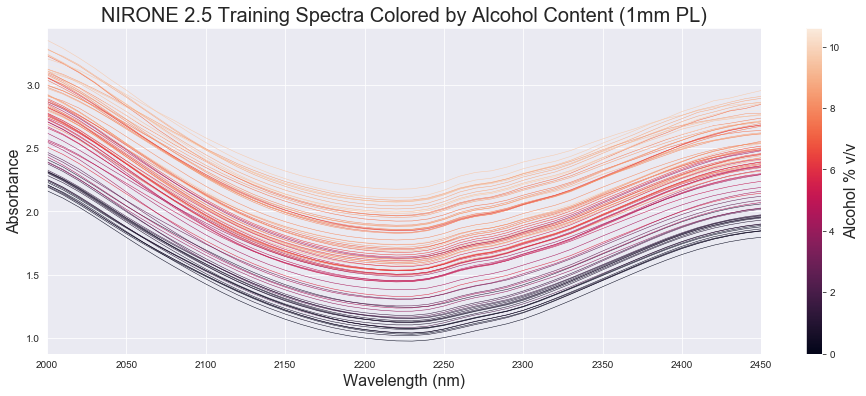

In [57]:
x = wavelengths
y = trainSpectra.values
z = trainDF['ALCIR']

ys = [i for i in y] #put into the format for LineCollection

# We need to set the plot limits, they will not autoscale
# fig, ax = plt.subplots(figsize=(8,3)) #for paper
fig, ax = plt.subplots(figsize=(16,6))
ax.set_xlim(np.min(x), np.max(x))
ax.set_ylim(np.min(ys)-.1, np.max(ys)+.1)
# # Make a sequence of x,y pairs
line_segments = LineCollection([np.column_stack([x, y]) for y in ys],
                               array = z,
                               linewidths=0.5,
                               linestyles='solid')

ax.add_collection(line_segments)
axcb = fig.colorbar(line_segments)
axcb.set_label('Alcohol % v/v', fontsize=16)
ax.set_title("NIRONE 2.5 Training Spectra Colored by Alcohol Content (1mm PL)", fontsize=20)
ax.set_ylabel("Absorbance", fontsize = 16)
ax.set_xlabel("Wavelength (nm)", fontsize = 16)
plt.show()

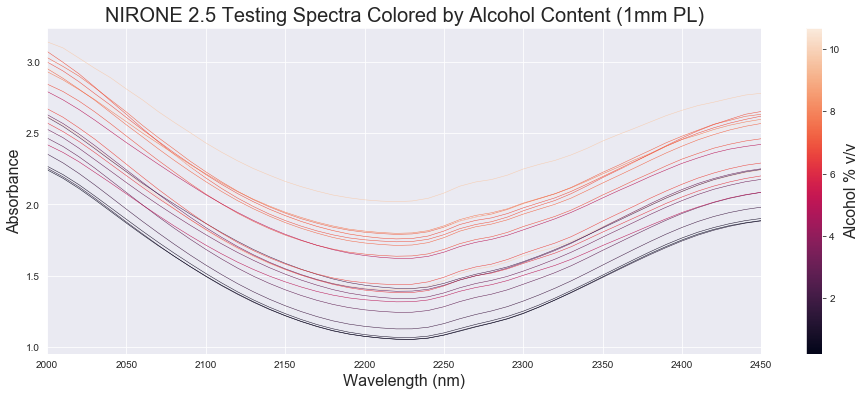

In [58]:
x = wavelengths
y = testSpectra.values
z = testDF['ALCIR']

ys = [i for i in y] #put into the format for LineCollection

# We need to set the plot limits, they will not autoscale
# fig, ax = plt.subplots(figsize=(8,3)) #for paper
fig, ax = plt.subplots(figsize=(16,6))
ax.set_xlim(np.min(x), np.max(x))
ax.set_ylim(np.min(ys)-.1, np.max(ys)+.1)
# # Make a sequence of x,y pairs
line_segments = LineCollection([np.column_stack([x, y]) for y in ys],
                               array = z,
                               linewidths=0.5,
                               linestyles='solid')

ax.add_collection(line_segments)
axcb = fig.colorbar(line_segments)
axcb.set_label('Alcohol % v/v', fontsize=16)
ax.set_title("NIRONE 2.5 Testing Spectra Colored by Alcohol Content (1mm PL)", fontsize=20)
ax.set_ylabel("Absorbance", fontsize = 16)
ax.set_xlabel("Wavelength (nm)", fontsize = 16)
plt.show()

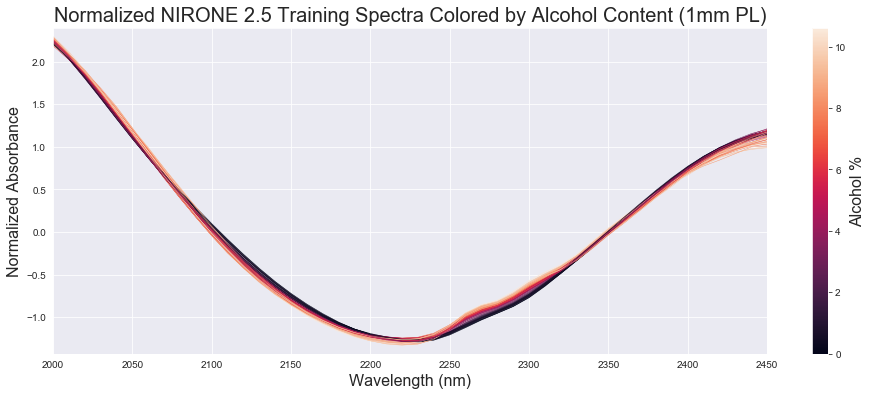

In [59]:
x = wavelengths
y = scaledTrainSpectra
z = trainDF['ALCIR']

ys = [i for i in y] #put into the format for LineCollection

# We need to set the plot limits, they will not autoscale
# fig, ax = plt.subplots(figsize=(8,3)) #for paper
fig, ax = plt.subplots(figsize=(16,6))
ax.set_xlim(np.min(x), np.max(x))
ax.set_ylim(np.min(ys)-.1, np.max(ys)+.1)
# # Make a sequence of x,y pairs
line_segments = LineCollection([np.column_stack([x, y]) for y in ys],
                               array = z,
                               linewidths=0.5,
                               linestyles='solid')

ax.add_collection(line_segments)
axcb = fig.colorbar(line_segments)
axcb.set_label('Alcohol %', fontsize=16)
ax.set_title("Normalized NIRONE 2.5 Training Spectra Colored by Alcohol Content (1mm PL)", fontsize=20)
ax.set_ylabel("Normalized Absorbance", fontsize = 16)
ax.set_xlabel("Wavelength (nm)", fontsize = 16)
plt.show()

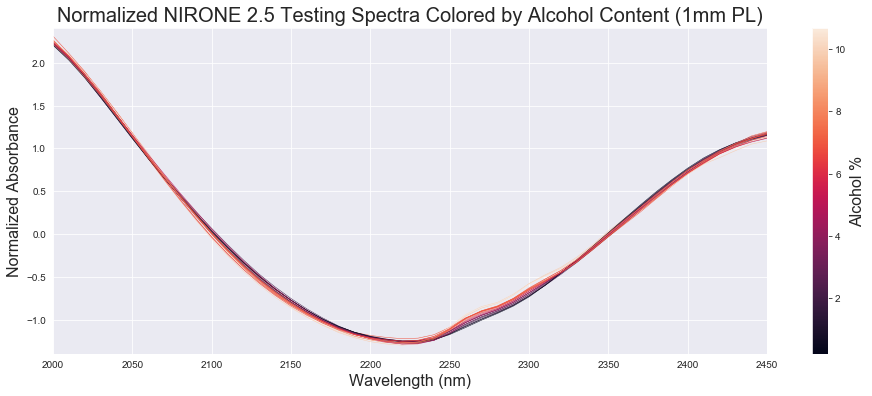

In [60]:
x = wavelengths
y = scaledTestSpectra
z = testDF['ALCIR']

ys = [i for i in y] #put into the format for LineCollection

# We need to set the plot limits, they will not autoscale
# fig, ax = plt.subplots(figsize=(8,3)) #for paper
fig, ax = plt.subplots(figsize=(16,6))
ax.set_xlim(np.min(x), np.max(x))
ax.set_ylim(np.min(ys)-.1, np.max(ys)+.1)
# # Make a sequence of x,y pairs
line_segments = LineCollection([np.column_stack([x, y]) for y in ys],
                               array = z,
                               linewidths=0.5,
                               linestyles='solid')

ax.add_collection(line_segments)
axcb = fig.colorbar(line_segments)
axcb.set_label('Alcohol %', fontsize=16)
ax.set_title("Normalized NIRONE 2.5 Testing Spectra Colored by Alcohol Content (1mm PL)", fontsize=20)
ax.set_ylabel("Normalized Absorbance", fontsize = 16)
ax.set_xlabel("Wavelength (nm)", fontsize = 16)
plt.show()

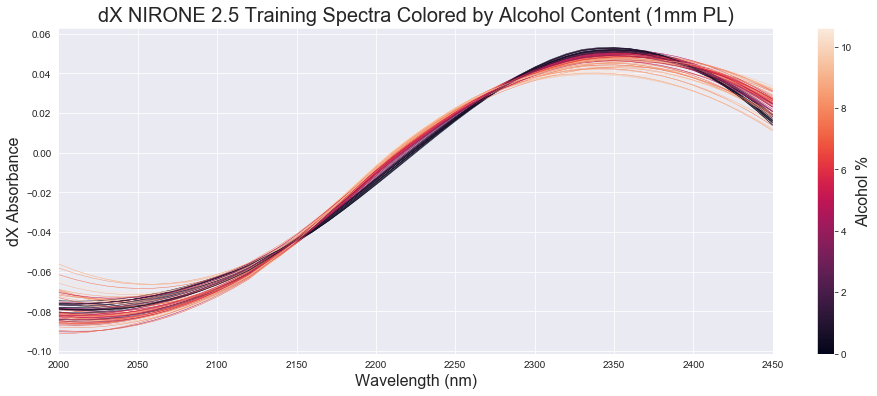

In [61]:
x = wavelengths
y = dXTrainSpectra
z = trainDF['ALCIR']

ys = [i for i in y] #put into the format for LineCollection

# We need to set the plot limits, they will not autoscale
# fig, ax = plt.subplots(figsize=(8,3)) #for paper
fig, ax = plt.subplots(figsize=(16,6))
ax.set_xlim(np.min(x), np.max(x))
ax.set_ylim(np.min(ys)-.01, np.max(ys)+.01)
# # Make a sequence of x,y pairs
line_segments = LineCollection([np.column_stack([x, y]) for y in ys],
                               array = z,
                               linewidths=0.5,
                               linestyles='solid')

ax.add_collection(line_segments)
axcb = fig.colorbar(line_segments)
axcb.set_label('Alcohol %', fontsize=16)
ax.set_title("dX NIRONE 2.5 Training Spectra Colored by Alcohol Content (1mm PL)", fontsize=20)
ax.set_ylabel("dX Absorbance", fontsize = 16)
ax.set_xlabel("Wavelength (nm)", fontsize = 16)
plt.show()

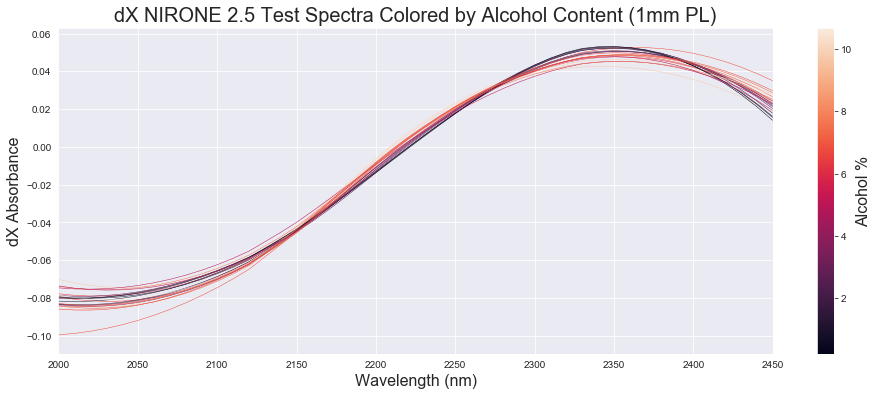

In [62]:
x = wavelengths
y = dXTestSpectra
z = testDF['ALCIR']

ys = [i for i in y] #put into the format for LineCollection

# We need to set the plot limits, they will not autoscale
# fig, ax = plt.subplots(figsize=(8,3)) #for paper
fig, ax = plt.subplots(figsize=(16,6))
ax.set_xlim(np.min(x), np.max(x))
ax.set_ylim(np.min(ys)-.01, np.max(ys)+.01)
# # Make a sequence of x,y pairs
line_segments = LineCollection([np.column_stack([x, y]) for y in ys],
                               array = z,
                               linewidths=0.5,
                               linestyles='solid')

ax.add_collection(line_segments)
axcb = fig.colorbar(line_segments)
axcb.set_label('Alcohol %', fontsize=16)
ax.set_title("dX NIRONE 2.5 Test Spectra Colored by Alcohol Content (1mm PL)", fontsize=20)
ax.set_ylabel("dX Absorbance", fontsize = 16)
ax.set_xlabel("Wavelength (nm)", fontsize = 16)
plt.show()

# Try PLS

optimal number of components = 6


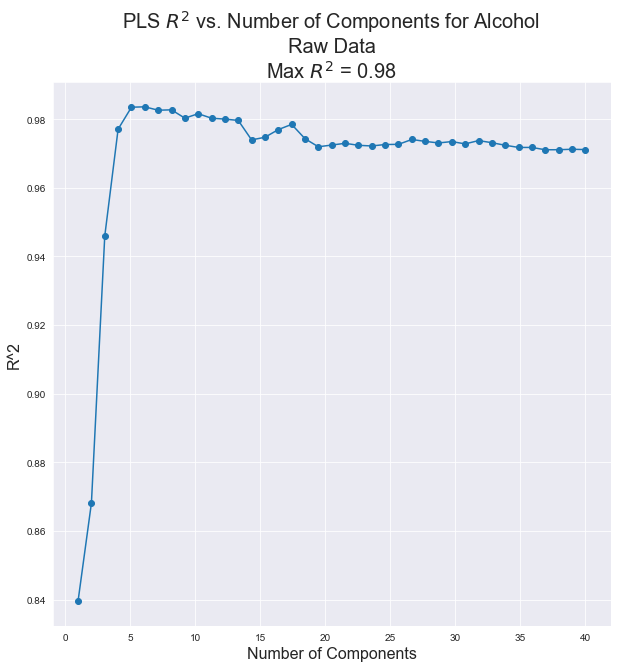

In [63]:
r2List =[]
for i in range(1,40):
    PLS = PLSRegression(n_components=i)
    X = trainSpectra
    y = trainDF['ALCIR']

#     print(X.shape,y.shape)
#     print()
    scores = cross_val_score(PLS,X,y,cv=9)
    medianR2 = np.median(scores)
    r2List.append(medianR2)
#     print(scores)
#     print("Median: {}".format(medianR2))
fig,ax = plt.subplots(figsize=(10,10))
ax.plot(np.linspace(1,40,39),r2List, marker='o')
ax.set_xlabel("Number of Components", fontsize = 16)
ax.set_ylabel("R^2", fontsize = 16)
ax.set_title("PLS $R^2$ vs. Number of Components for Alcohol \nRaw Data\nMax $R^2$ = {}".format(np.round(np.max(r2List),2)), fontsize = 20)

print("optimal number of components = "+ str(np.where(r2List == np.amax(r2List))[0][0]+1))

optimal number of components = 6


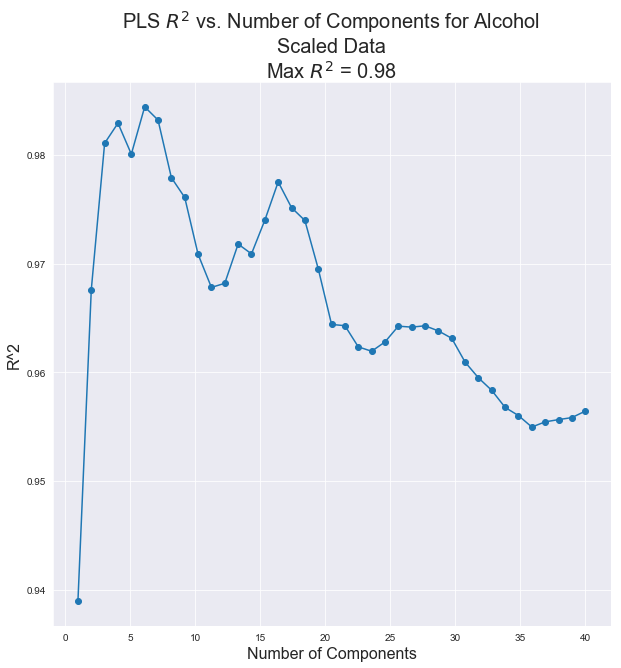

In [64]:
r2List =[]
for i in range(1,40):
    PLS = PLSRegression(n_components=i)
    X = scaledTrainSpectra
    y = trainDF['ALCIR']

#     print(X.shape,y.shape)
#     print()
    scores = cross_val_score(PLS,X,y,cv=9)
    medianR2 = np.median(scores)
    r2List.append(medianR2)
#     print(scores)
#     print("Median: {}".format(medianR2))
fig,ax = plt.subplots(figsize=(10,10))
ax.plot(np.linspace(1,40,39),r2List, marker='o')
ax.set_xlabel("Number of Components", fontsize = 16)
ax.set_ylabel("R^2", fontsize = 16)
ax.set_title("PLS $R^2$ vs. Number of Components for Alcohol \nScaled Data\nMax $R^2$ = {}".format(np.round(np.max(r2List),2)), fontsize = 20)

print("optimal number of components = "+ str(np.where(r2List == np.amax(r2List))[0][0]+1))

optimal number of components = 7


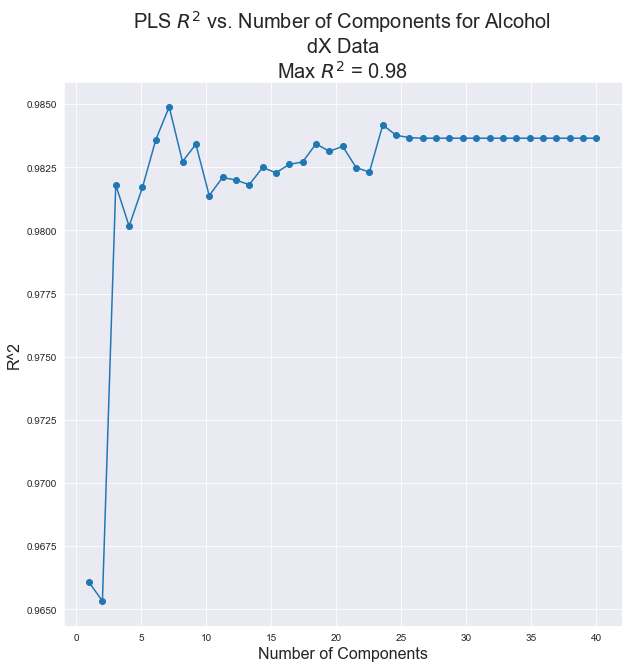

In [67]:
r2List =[]
for i in range(1,40):
    PLS = PLSRegression(n_components=i)
    X = dXTrainSpectra
    y = trainDF['ALCIR']

#     print(X.shape,y.shape)
#     print()
    scores = cross_val_score(PLS,X,y,cv=9)
    medianR2 = np.median(scores)
    r2List.append(medianR2)
#     print(scores)
#     print("Median: {}".format(medianR2))
fig,ax = plt.subplots(figsize=(10,10))
ax.plot(np.linspace(1,40,39),r2List, marker='o')
ax.set_xlabel("Number of Components", fontsize = 16)
ax.set_ylabel("R^2", fontsize = 16)
ax.set_title("PLS $R^2$ vs. Number of Components for Alcohol \ndX Data\nMax $R^2$ = {}".format(np.round(np.max(r2List),2)), fontsize = 20)

print("optimal number of components = "+ str(np.where(r2List == np.amax(r2List))[0][0]+1))

optimal number of components = 7


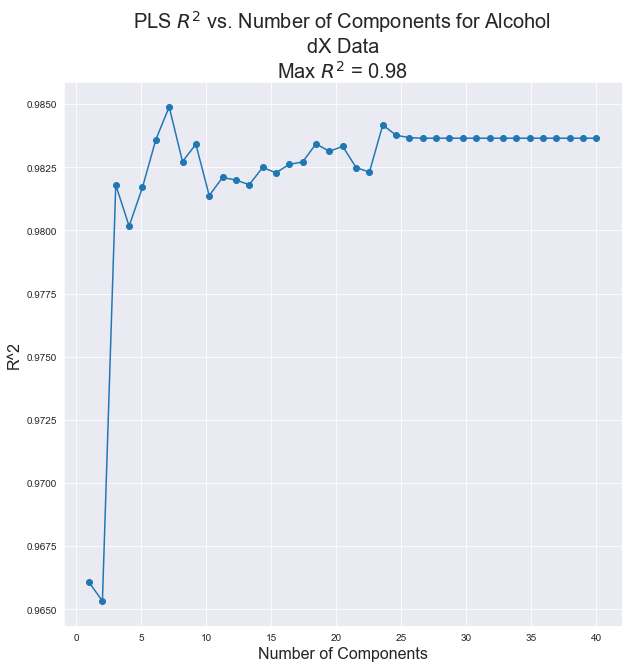

In [68]:
r2List =[]
for i in range(1,40):
    PLS = PLSRegression(n_components=i)
    X = dXTrainSpectra
    y = trainDF['ALCIR']

#     print(X.shape,y.shape)
#     print()
    scores = cross_val_score(PLS,X,y,cv=9)
    medianR2 = np.median(scores)
    r2List.append(medianR2)
#     print(scores)
#     print("Median: {}".format(medianR2))
fig,ax = plt.subplots(figsize=(10,10))
ax.plot(np.linspace(1,40,39),r2List, marker='o')
ax.set_xlabel("Number of Components", fontsize = 16)
ax.set_ylabel("R^2", fontsize = 16)
ax.set_title("PLS $R^2$ vs. Number of Components for Alcohol \ndX Data\nMax $R^2$ = {}".format(np.round(np.max(r2List),2)), fontsize = 20)

print("optimal number of components = "+ str(np.where(r2List == np.amax(r2List))[0][0]+1))

# From this analysis we will use raw data with 6 principal components

In [69]:
target = "ALCIR"
model = PLSRegression(n_components=6)
X = trainSpectra
y = trainDF[target]

model.fit(X,y)
pred = model.predict(testSpectra)
r2 = r2_score(y_true=testDF[target], y_pred=pred)
rmsep = np.sqrt(mean_squared_error(y_true=testDF[target], y_pred=pred))
r2, rmsep

(0.9865846632845923, 0.3532812495404817)

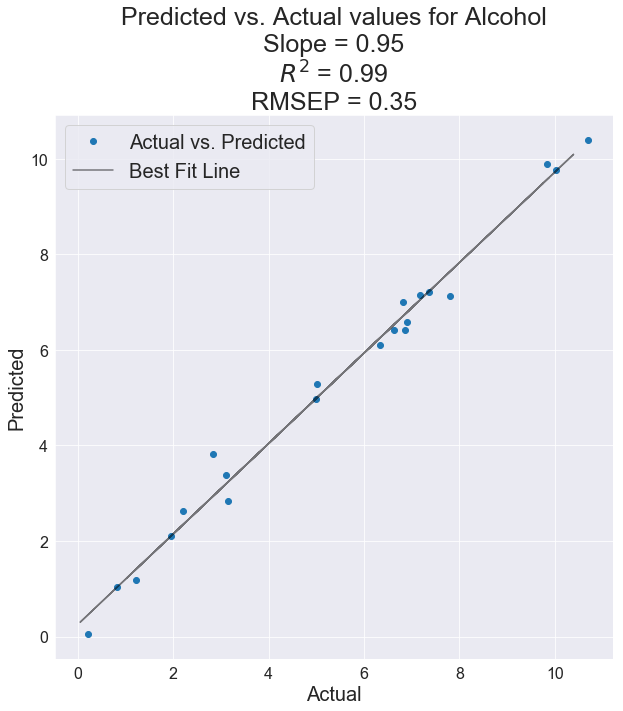

In [70]:
slope,intercept = np.polyfit(testDF[target],pred.reshape(pred.shape[0]),1)
f = np.poly1d([slope,intercept]) 
fig,ax = plt.subplots(figsize = (10,10))
plt.plot(testDF[target],pred,'o', label="Actual vs. Predicted")
plt.plot(pred,f(pred), 'k-',label="Best Fit Line", alpha=0.5)
ax.set_xlabel("Actual", fontsize = 20)
ax.set_ylabel("Predicted", fontsize = 20)
ax.set_title("Predicted vs. Actual values for Alcohol\nSlope = {}\n$R^2$ = {}\nRMSEP = {}".format(np.round(slope,2),np.round(r2,2), np.round(rmsep,2)), fontsize=25);
ax.legend(prop={"size":20});
for tick in ax.xaxis.get_major_ticks():
    tick.label.set_fontsize(16) 
    
for tick in ax.yaxis.get_major_ticks():
    tick.label.set_fontsize(16) 

# Now we try SVR

In [75]:
target = 'ALCIR'
gsc = GridSearchCV(
        estimator=SVR(kernel='rbf'),
        param_grid={
            'C': [0.1, 1, 100, 1000,10000,100000],
            'epsilon': [0.0001, 0.0005, 0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1, 5, 10],
            'gamma': [0.0001, 0.001, 0.005, 0.1, 1, 3, 5]
        },
        cv=9, scoring='neg_mean_squared_error', verbose=0, n_jobs=-1)
grid_result = gsc.fit(scaledTrainSpectra, trainDF[target])
best_params = grid_result.best_params_
best_params

{'C': 1000, 'epsilon': 0.05, 'gamma': 1}

In [76]:
model = SVR(kernel='rbf',
            C=best_params['C'],
            epsilon=best_params['epsilon'],
            gamma=best_params['gamma'])

X = scaledTrainSpectra
y = trainDF[target]

model.fit(X,y)
pred = model.predict(scaledTestSpectra)
r2 = r2_score(y_true=testDF[target], y_pred=pred)
rmsep = np.sqrt(mean_squared_error(y_true=testDF[target], y_pred=pred))
r2, rmsep

(0.9896166161920935, 0.31080589879494663)

In [73]:
# target = 'ALCIR'
# gsc = GridSearchCV(
#         estimator=SVR(kernel='linear'),
#         param_grid={
#             'C': [0.1, 1, 100, 1000,10000,100000]
#         },
#         cv=9, scoring='neg_mean_squared_error', verbose=0, n_jobs=-1)

# grid_result = gsc.fit(scaledTrainSpectra, trainDF[target])
# best_params = grid_result.best_params_
# best_params

{'C': 1000}

In [74]:
# model = SVR(kernel='linear',
#            C = best_params['C'],
#            gamma='auto')
# X = scaledTrainSpectra
# y = trainDF[target]

# model.fit(X,y)
# pred = model.predict(scaledTestSpectra)
# r2 = r2_score(y_true=testDF[target], y_pred=pred)
# rmsep = np.sqrt(mean_squared_error(y_true=testDF[target], y_pred=pred))
# r2, rmsep

(0.9831946491941982, 0.39540630516058073)

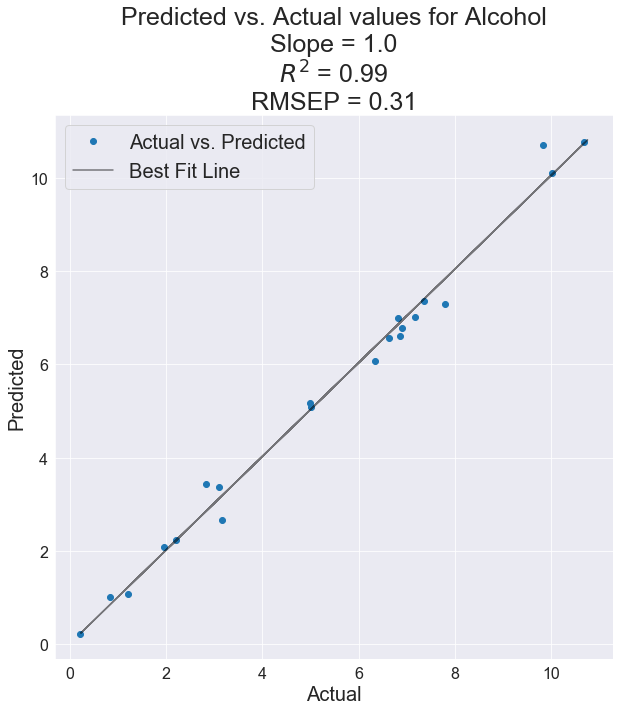

In [77]:
slope,intercept = np.polyfit(testDF[target],pred.reshape(pred.shape[0]),1)
f = np.poly1d([slope,intercept]) 
fig,ax = plt.subplots(figsize = (10,10))
plt.plot(testDF[target],pred,'o', label="Actual vs. Predicted")
plt.plot(pred,f(pred), 'k-',label="Best Fit Line", alpha=0.5)
ax.set_xlabel("Actual", fontsize = 20)
ax.set_ylabel("Predicted", fontsize = 20)
ax.set_title("Predicted vs. Actual values for Alcohol\nSlope = {}\n$R^2$ = {}\nRMSEP = {}".format(np.round(slope,2),np.round(r2,2), np.round(rmsep,2)), fontsize=25);
ax.legend(prop={"size":20});
for tick in ax.xaxis.get_major_ticks():
    tick.label.set_fontsize(16) 
    
for tick in ax.yaxis.get_major_ticks():
    tick.label.set_fontsize(16) 

# Now try Random Forest

In [78]:
target = "ALCIR"
model = RandomForestRegressor(n_estimators=100, max_features='sqrt')
X = scaledTrainSpectra
y = trainDF[target]

model.fit(X,y)
pred = model.predict(scaledTestSpectra)
r2 = r2_score(y_true=testDF[target], y_pred=pred)
rmsep = np.sqrt(mean_squared_error(y_true=testDF[target], y_pred=pred))
r2, rmsep

(0.9611924071792697, 0.6008667212174964)

# Sugar

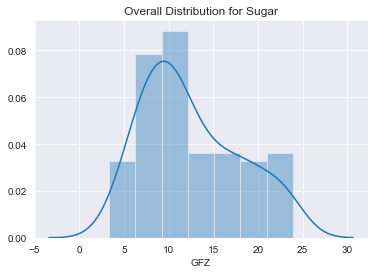

In [79]:
target = 'GFZ'
#check out the distribution for Alcohol
sns.distplot(meanDF[target])
plt.title("Overall Distribution for Sugar");

In [80]:
#Divide into categories
meanDF['GFZ_categories'] = np.ceil(meanDF['GFZ']/3)
meanDF.GFZ_categories.value_counts().sort_index()

2.0     9
3.0    24
4.0    27
5.0    12
6.0    11
7.0    11
8.0    10
Name: GFZ_categories, dtype: int64

In [81]:
split = StratifiedShuffleSplit(n_splits=1,test_size=0.2, random_state=42)

for train_index, test_index in split.split(meanDF,meanDF["GFZ_categories"]):
    trainDF = meanDF.reset_index().loc[train_index]
    testDF = meanDF.reset_index().loc[test_index]
#get rid of the *_categories
meanDF = meanDF.drop("GFZ_categories", axis=1)
trainDF = trainDF.drop("GFZ_categories", axis=1)
testDF = testDF.drop("GFZ_categories", axis=1)

In [82]:
trainDF = trainDF.reset_index(drop=True)
testDF = testDF.reset_index(drop=True)
trainDF.shape, testDF.shape

((83, 55), (21, 55))

Text(0.5, 1.0, 'Training Distribution for Sugar')

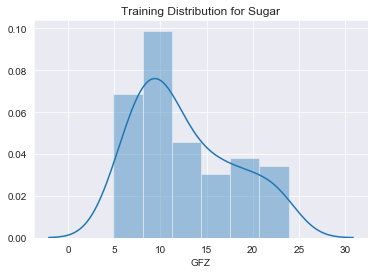

In [83]:
#check out the distribution for Sugar
sns.distplot(trainDF[target])
plt.title("Training Distribution for Sugar")

Text(0.5, 1.0, 'Testing Distribution for Sugar')

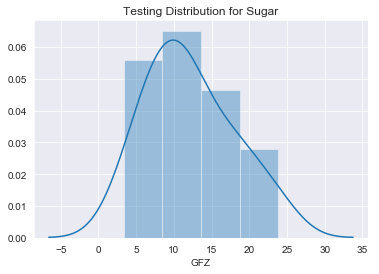

In [84]:
#check out the distribution for Sugar
sns.distplot(testDF[target])
plt.title("Testing Distribution for Sugar")

In [85]:
#perform necessary preprocessing on the data
dropColumns = targetColumns + ['key']
trainSpectra = trainDF.drop(dropColumns,axis=1)
testSpectra = testDF.drop(dropColumns,axis=1)
print(trainSpectra.shape,testSpectra.shape)

#scale the data
scaledTrainSpectra = np.transpose(StandardScaler().fit_transform(np.transpose(trainSpectra.values)))
scaledTestSpectra = np.transpose(StandardScaler().fit_transform(np.transpose(testSpectra.values)))

#derivative of the data
dXTrainSpectra = savgol_filter(trainSpectra.values, window_length=25, polyorder=3,deriv=1)
dXTestSpectra = savgol_filter(testSpectra.values, window_length=25, polyorder=3, deriv=1)

ddXTrainSpectra = savgol_filter(trainSpectra.values, window_length=25, polyorder=3,deriv=2)
ddXTestSpectra = savgol_filter(testSpectra.values, window_length=25, polyorder=3, deriv=2)

(83, 46) (21, 46)


# Visualizing the Training and Testing sets

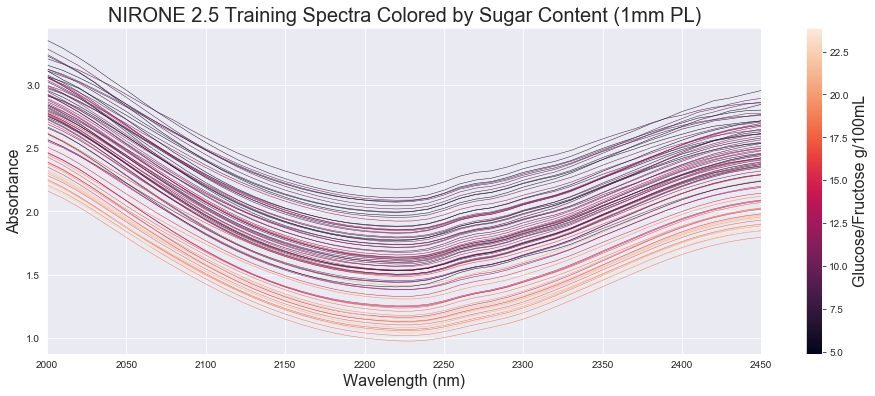

In [86]:
x = wavelengths
y = trainSpectra.values
z = trainDF[target]

ys = [i for i in y] #put into the format for LineCollection

# We need to set the plot limits, they will not autoscale
# fig, ax = plt.subplots(figsize=(8,3)) #for paper
fig, ax = plt.subplots(figsize=(16,6))
ax.set_xlim(np.min(x), np.max(x))
ax.set_ylim(np.min(ys)-.1, np.max(ys)+.1)
# # Make a sequence of x,y pairs
line_segments = LineCollection([np.column_stack([x, y]) for y in ys],
                               array = z,
                               linewidths=0.5,
                               linestyles='solid')

ax.add_collection(line_segments)
axcb = fig.colorbar(line_segments)
axcb.set_label('Glucose/Fructose g/100mL', fontsize=16)
ax.set_title("NIRONE 2.5 Training Spectra Colored by Sugar Content (1mm PL)", fontsize=20)
ax.set_ylabel("Absorbance", fontsize = 16)
ax.set_xlabel("Wavelength (nm)", fontsize = 16)
plt.show()

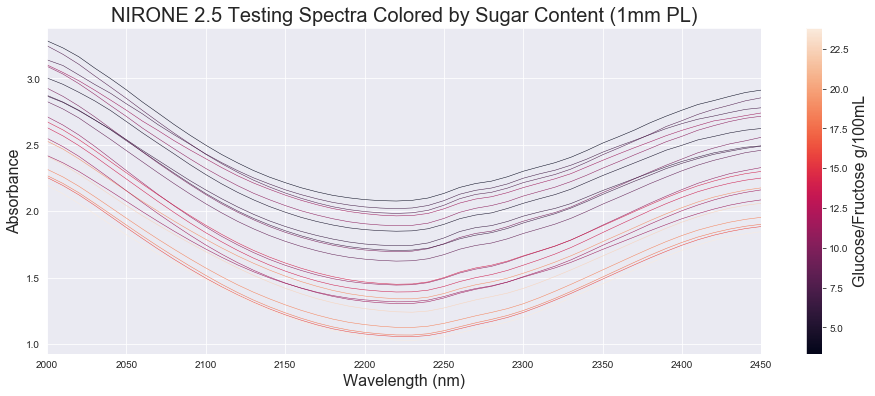

In [87]:
x = wavelengths
y = testSpectra.values
z = testDF[target]

ys = [i for i in y] #put into the format for LineCollection

# We need to set the plot limits, they will not autoscale
# fig, ax = plt.subplots(figsize=(8,3)) #for paper
fig, ax = plt.subplots(figsize=(16,6))
ax.set_xlim(np.min(x), np.max(x))
ax.set_ylim(np.min(ys)-.1, np.max(ys)+.1)
# # Make a sequence of x,y pairs
line_segments = LineCollection([np.column_stack([x, y]) for y in ys],
                               array = z,
                               linewidths=0.5,
                               linestyles='solid')

ax.add_collection(line_segments)
axcb = fig.colorbar(line_segments)
axcb.set_label('Glucose/Fructose g/100mL', fontsize=16)
ax.set_title("NIRONE 2.5 Testing Spectra Colored by Sugar Content (1mm PL)", fontsize=20)
ax.set_ylabel("Absorbance", fontsize = 16)
ax.set_xlabel("Wavelength (nm)", fontsize = 16)
plt.show()

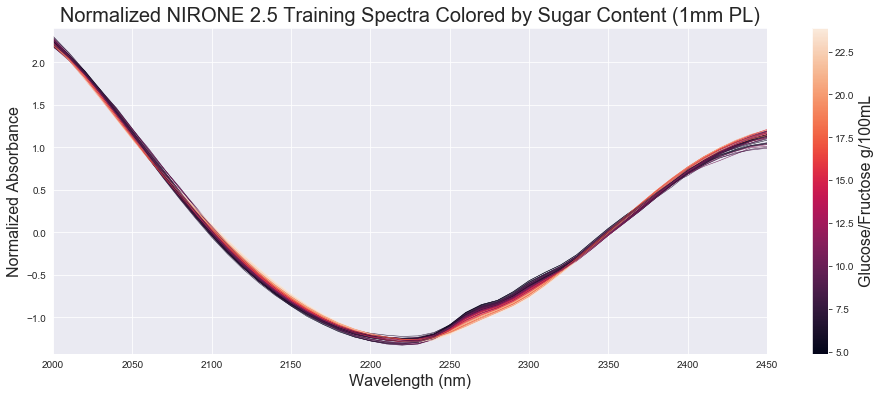

In [88]:
x = wavelengths
y = scaledTrainSpectra
z = trainDF[target]

ys = [i for i in y] #put into the format for LineCollection

# We need to set the plot limits, they will not autoscale
# fig, ax = plt.subplots(figsize=(8,3)) #for paper
fig, ax = plt.subplots(figsize=(16,6))
ax.set_xlim(np.min(x), np.max(x))
ax.set_ylim(np.min(ys)-.1, np.max(ys)+.1)
# # Make a sequence of x,y pairs
line_segments = LineCollection([np.column_stack([x, y]) for y in ys],
                               array = z,
                               linewidths=0.5,
                               linestyles='solid')

ax.add_collection(line_segments)
axcb = fig.colorbar(line_segments)
axcb.set_label('Glucose/Fructose g/100mL', fontsize=16)
ax.set_title("Normalized NIRONE 2.5 Training Spectra Colored by Sugar Content (1mm PL)", fontsize=20)
ax.set_ylabel("Normalized Absorbance", fontsize = 16)
ax.set_xlabel("Wavelength (nm)", fontsize = 16)
plt.show()

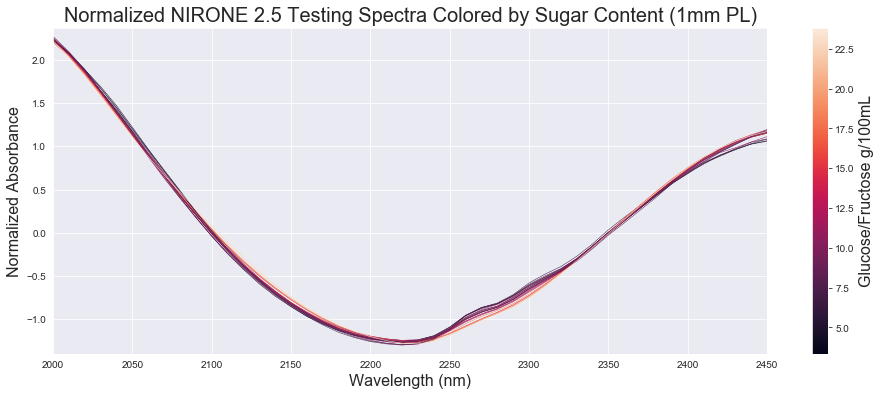

In [89]:
x = wavelengths
y = scaledTestSpectra
z = testDF[target]

ys = [i for i in y] #put into the format for LineCollection

# We need to set the plot limits, they will not autoscale
# fig, ax = plt.subplots(figsize=(8,3)) #for paper
fig, ax = plt.subplots(figsize=(16,6))
ax.set_xlim(np.min(x), np.max(x))
ax.set_ylim(np.min(ys)-.1, np.max(ys)+.1)
# # Make a sequence of x,y pairs
line_segments = LineCollection([np.column_stack([x, y]) for y in ys],
                               array = z,
                               linewidths=0.5,
                               linestyles='solid')

ax.add_collection(line_segments)
axcb = fig.colorbar(line_segments)
axcb.set_label('Glucose/Fructose g/100mL', fontsize=16)
ax.set_title("Normalized NIRONE 2.5 Testing Spectra Colored by Sugar Content (1mm PL)", fontsize=20)
ax.set_ylabel("Normalized Absorbance", fontsize = 16)
ax.set_xlabel("Wavelength (nm)", fontsize = 16)
plt.show()

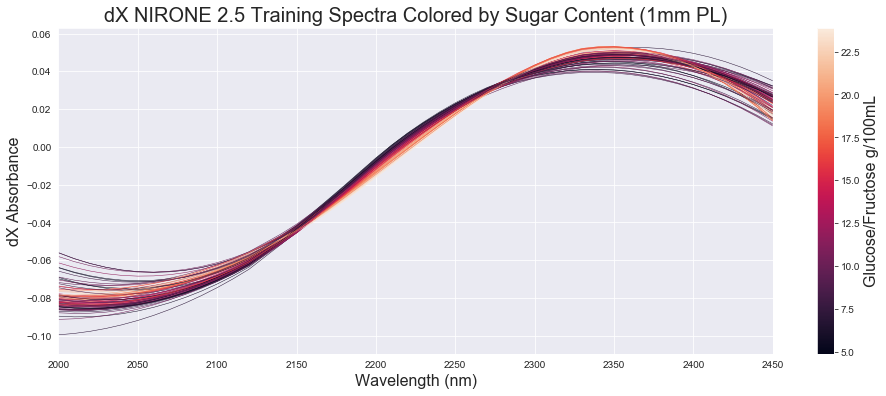

In [90]:
x = wavelengths
y = dXTrainSpectra
z = trainDF[target]

ys = [i for i in y] #put into the format for LineCollection

# We need to set the plot limits, they will not autoscale
# fig, ax = plt.subplots(figsize=(8,3)) #for paper
fig, ax = plt.subplots(figsize=(16,6))
ax.set_xlim(np.min(x), np.max(x))
ax.set_ylim(np.min(ys)-.01, np.max(ys)+.01)
# # Make a sequence of x,y pairs
line_segments = LineCollection([np.column_stack([x, y]) for y in ys],
                               array = z,
                               linewidths=0.5,
                               linestyles='solid')

ax.add_collection(line_segments)
axcb = fig.colorbar(line_segments)
axcb.set_label('Glucose/Fructose g/100mL', fontsize=16)
ax.set_title("dX NIRONE 2.5 Training Spectra Colored by Sugar Content (1mm PL)", fontsize=20)
ax.set_ylabel("dX Absorbance", fontsize = 16)
ax.set_xlabel("Wavelength (nm)", fontsize = 16)
plt.show()

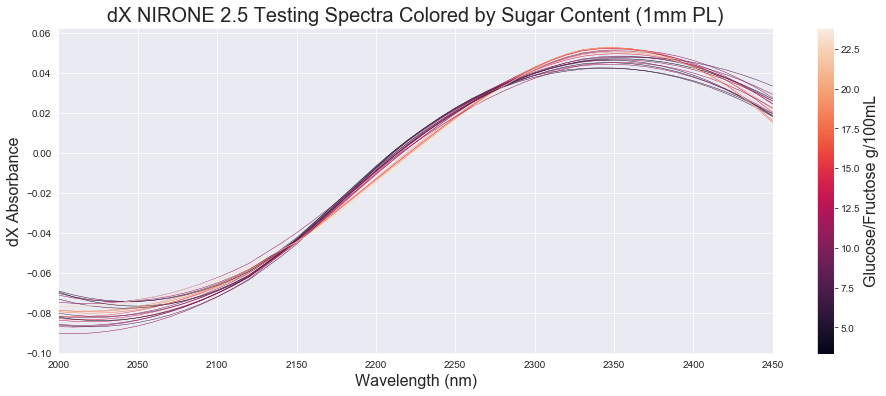

In [91]:
x = wavelengths
y = dXTestSpectra
z = testDF[target]

ys = [i for i in y] #put into the format for LineCollection

# We need to set the plot limits, they will not autoscale
# fig, ax = plt.subplots(figsize=(8,3)) #for paper
fig, ax = plt.subplots(figsize=(16,6))
ax.set_xlim(np.min(x), np.max(x))
ax.set_ylim(np.min(ys)-.01, np.max(ys)+.01)
# # Make a sequence of x,y pairs
line_segments = LineCollection([np.column_stack([x, y]) for y in ys],
                               array = z,
                               linewidths=0.5,
                               linestyles='solid')

ax.add_collection(line_segments)
axcb = fig.colorbar(line_segments)
axcb.set_label('Glucose/Fructose g/100mL', fontsize=16)
ax.set_title("dX NIRONE 2.5 Testing Spectra Colored by Sugar Content (1mm PL)", fontsize=20)
ax.set_ylabel("dX Absorbance", fontsize = 16)
ax.set_xlabel("Wavelength (nm)", fontsize = 16)
plt.show()

# PLS

optimal number of components = 9


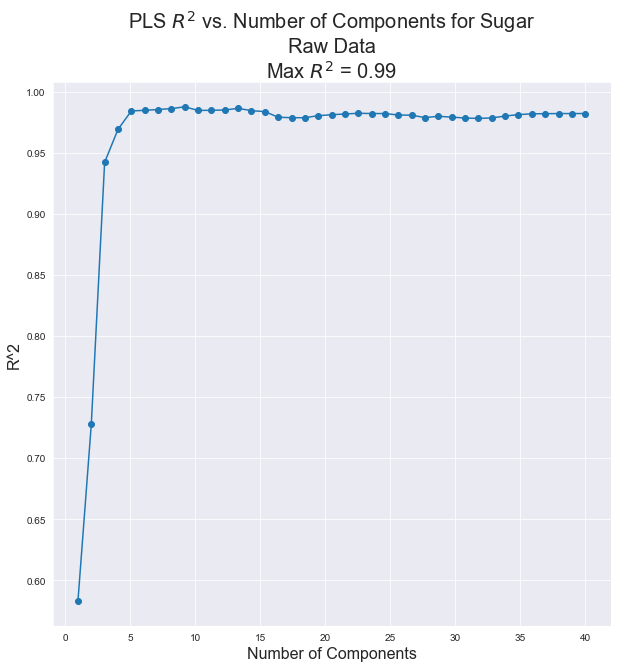

In [92]:
r2List =[]
for i in range(1,40):
    PLS = PLSRegression(n_components=i)
    X = trainSpectra
    y = trainDF[target]

#     print(X.shape,y.shape)
#     print()
    scores = cross_val_score(PLS,X,y,cv=9)
    medianR2 = np.median(scores)
    r2List.append(medianR2)
#     print(scores)
#     print("Median: {}".format(medianR2))
fig,ax = plt.subplots(figsize=(10,10))
ax.plot(np.linspace(1,40,39),r2List, marker='o')
ax.set_xlabel("Number of Components", fontsize = 16)
ax.set_ylabel("R^2", fontsize = 16)
ax.set_title("PLS $R^2$ vs. Number of Components for Sugar \nRaw Data\nMax $R^2$ = {}".format(np.round(np.max(r2List),2)), fontsize = 20)

print("optimal number of components = "+ str(np.where(r2List == np.amax(r2List))[0][0]+1))

optimal number of components = 10


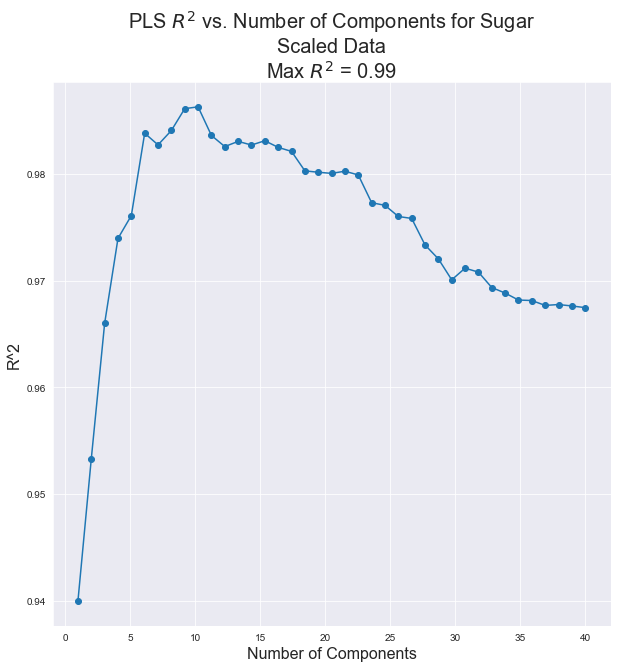

In [93]:
r2List =[]
for i in range(1,40):
    PLS = PLSRegression(n_components=i)
    X = scaledTrainSpectra
    y = trainDF[target]

#     print(X.shape,y.shape)
#     print()
    scores = cross_val_score(PLS,X,y,cv=9)
    medianR2 = np.median(scores)
    r2List.append(medianR2)
#     print(scores)
#     print("Median: {}".format(medianR2))
fig,ax = plt.subplots(figsize=(10,10))
ax.plot(np.linspace(1,40,39),r2List, marker='o')
ax.set_xlabel("Number of Components", fontsize = 16)
ax.set_ylabel("R^2", fontsize = 16)
ax.set_title("PLS $R^2$ vs. Number of Components for Sugar \nScaled Data\nMax $R^2$ = {}".format(np.round(np.max(r2List),2)), fontsize = 20)

print("optimal number of components = "+ str(np.where(r2List == np.amax(r2List))[0][0]+1))

optimal number of components = 6


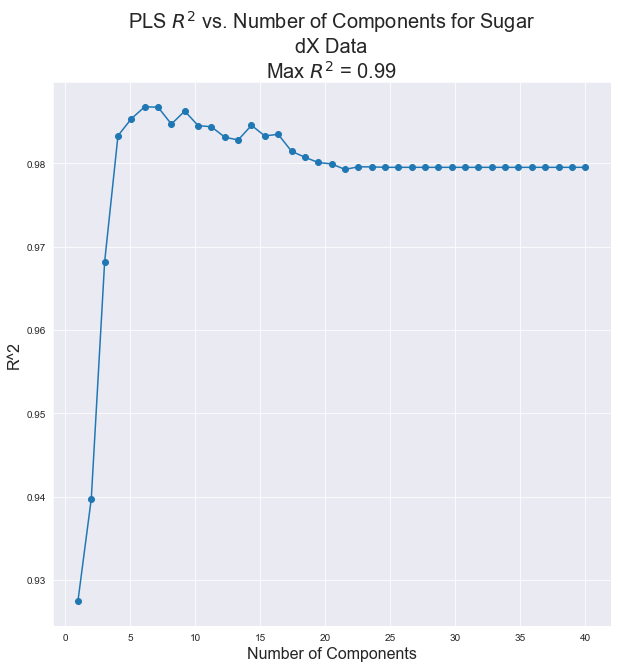

In [94]:
r2List =[]
for i in range(1,40):
    PLS = PLSRegression(n_components=i)
    X = dXTrainSpectra
    y = trainDF[target]

#     print(X.shape,y.shape)
#     print()
    scores = cross_val_score(PLS,X,y,cv=9)
    medianR2 = np.median(scores)
    r2List.append(medianR2)
#     print(scores)
#     print("Median: {}".format(medianR2))
fig,ax = plt.subplots(figsize=(10,10))
ax.plot(np.linspace(1,40,39),r2List, marker='o')
ax.set_xlabel("Number of Components", fontsize = 16)
ax.set_ylabel("R^2", fontsize = 16)
ax.set_title("PLS $R^2$ vs. Number of Components for Sugar \ndX Data\nMax $R^2$ = {}".format(np.round(np.max(r2List),2)), fontsize = 20)

print("optimal number of components = "+ str(np.where(r2List == np.amax(r2List))[0][0]+1))

optimal number of components = 15


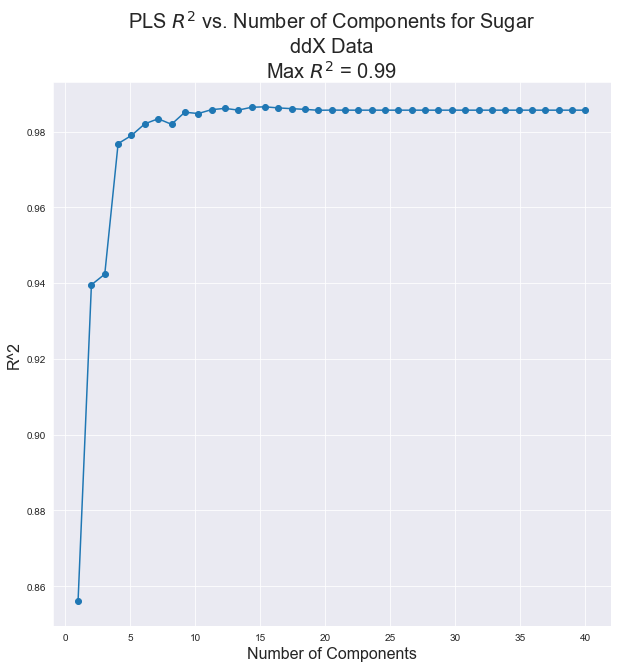

In [95]:
r2List =[]
for i in range(1,40):
    PLS = PLSRegression(n_components=i)
    X = ddXTrainSpectra
    y = trainDF[target]

#     print(X.shape,y.shape)
#     print()
    scores = cross_val_score(PLS,X,y,cv=9)
    medianR2 = np.median(scores)
    r2List.append(medianR2)
#     print(scores)
#     print("Median: {}".format(medianR2))
fig,ax = plt.subplots(figsize=(10,10))
ax.plot(np.linspace(1,40,39),r2List, marker='o')
ax.set_xlabel("Number of Components", fontsize = 16)
ax.set_ylabel("R^2", fontsize = 16)
ax.set_title("PLS $R^2$ vs. Number of Components for Sugar \nddX Data\nMax $R^2$ = {}".format(np.round(np.max(r2List),2)), fontsize = 20)

print("optimal number of components = "+ str(np.where(r2List == np.amax(r2List))[0][0]+1))

# from this analysis we will use raw data with 9 components

In [96]:
model = PLSRegression(n_components=9)
X = trainSpectra
y = trainDF[target]

model.fit(X,y)
pred = model.predict(testSpectra)
r2 = r2_score(y_true=testDF[target], y_pred=pred)
rmsep = np.sqrt(mean_squared_error(y_true=testDF[target], y_pred=pred))
r2, rmsep

(0.967203768185459, 1.0157618544730094)

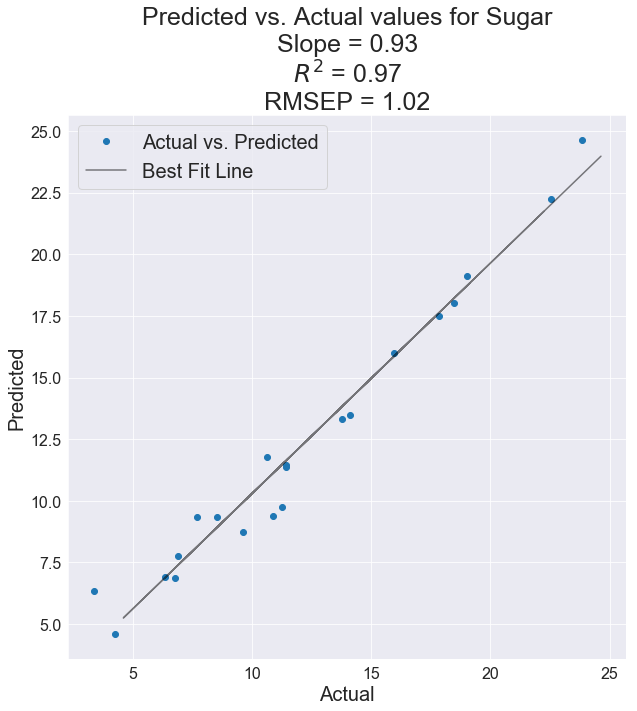

In [97]:
slope,intercept = np.polyfit(testDF[target],pred.reshape(pred.shape[0]),1)
f = np.poly1d([slope,intercept]) 
fig,ax = plt.subplots(figsize = (10,10))
plt.plot(testDF[target],pred,'o', label="Actual vs. Predicted")
plt.plot(pred,f(pred), 'k-',label="Best Fit Line", alpha=0.5)
ax.set_xlabel("Actual", fontsize = 20)
ax.set_ylabel("Predicted", fontsize = 20)
ax.set_title("Predicted vs. Actual values for Sugar\nSlope = {}\n$R^2$ = {}\nRMSEP = {}".format(np.round(slope,2),np.round(r2,2), np.round(rmsep,2)), fontsize=25);
ax.legend(prop={"size":20});
for tick in ax.xaxis.get_major_ticks():
    tick.label.set_fontsize(16) 
    
for tick in ax.yaxis.get_major_ticks():
    tick.label.set_fontsize(16) 

# Now we try SVR

In [98]:
# gsc = GridSearchCV(
#         estimator=SVR(kernel='rbf'),
#         param_grid={
#             'C': [0.1, 1, 100, 1000,10000,100000],
#             'epsilon': [0.0001, 0.0005, 0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1, 5, 10],
#             'gamma': [0.0001, 0.001, 0.005, 0.1, 1, 3, 5]
#         },
#         cv=9, scoring='neg_mean_squared_error', verbose=0, n_jobs=-1)
# grid_result = gsc.fit(scaledTrainSpectra, trainDF[target])
# best_params = grid_result.best_params_
# best_params

{'C': 10000, 'epsilon': 0.1, 'gamma': 1}

In [99]:
# model = SVR(kernel='rbf',
#             C=best_params['C'],
#             epsilon=best_params['epsilon'],
#             gamma=best_params['gamma'])

# X = scaledTrainSpectra
# y = trainDF[target]

# model.fit(X,y)
# pred = model.predict(scaledTestSpectra)
# r2 = r2_score(y_true=testDF[target], y_pred=pred)
# rmsep = np.sqrt(mean_squared_error(y_true=testDF[target], y_pred=pred))
# r2, rmsep

(0.9718367753294914, 0.9412849515132946)

In [100]:

gsc = GridSearchCV(
        estimator=SVR(kernel='linear'),
        param_grid={
            'C': [0.1, 1, 100, 1000,10000,100000]
        },
        cv=9, scoring='neg_mean_squared_error', verbose=0, n_jobs=-1)

grid_result = gsc.fit(scaledTrainSpectra, trainDF[target])
best_params = grid_result.best_params_
best_params

{'C': 10000}

In [101]:
model = SVR(kernel='linear',
           C = best_params['C'],
           gamma='auto')
X = scaledTrainSpectra
y = trainDF[target]

model.fit(X,y)
pred = model.predict(scaledTestSpectra)
r2 = r2_score(y_true=testDF[target], y_pred=pred)
rmsep = np.sqrt(mean_squared_error(y_true=testDF[target], y_pred=pred))
r2, rmsep

(0.975280450282777, 0.8818611360281967)

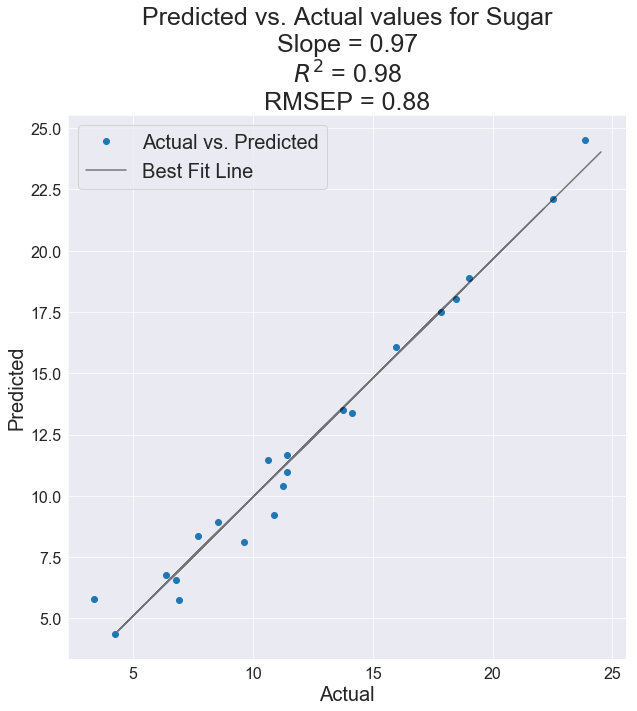

In [102]:
slope,intercept = np.polyfit(testDF[target],pred.reshape(pred.shape[0]),1)
f = np.poly1d([slope,intercept]) 
fig,ax = plt.subplots(figsize = (10,10))
plt.plot(testDF[target],pred,'o', label="Actual vs. Predicted")
plt.plot(pred,f(pred), 'k-',label="Best Fit Line", alpha=0.5)
ax.set_xlabel("Actual", fontsize = 20)
ax.set_ylabel("Predicted", fontsize = 20)
ax.set_title("Predicted vs. Actual values for Sugar\nSlope = {}\n$R^2$ = {}\nRMSEP = {}".format(np.round(slope,2),np.round(r2,2), np.round(rmsep,2)), fontsize=25);
ax.legend(prop={"size":20});
for tick in ax.xaxis.get_major_ticks():
    tick.label.set_fontsize(16) 
    
for tick in ax.yaxis.get_major_ticks():
    tick.label.set_fontsize(16) 

# Random Forest

In [103]:
model = RandomForestRegressor(n_estimators=100, max_features='sqrt')
X = scaledTrainSpectra
y = trainDF[target]

model.fit(X,y)
pred = model.predict(scaledTestSpectra)
r2 = r2_score(y_true=testDF[target], y_pred=pred)
rmsep = np.sqrt(mean_squared_error(y_true=testDF[target], y_pred=pred))
r2, rmsep

(0.9304691171071324, 1.4790021241814804)

# Now we will try Volatile Acidity (VAZ)

In [104]:
target = 'VAZ'

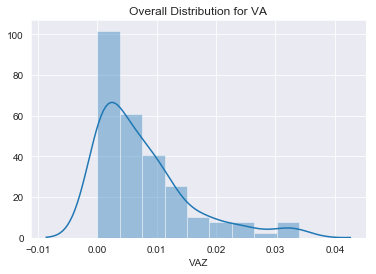

In [105]:
#check out the distribution for VA
sns.distplot(meanDF[target])
plt.title("Overall Distribution for VA");

In [106]:
#Divide into categories
meanDF['VAZ_categories'] = np.ceil(meanDF['VAZ']/.01)
meanDF.VAZ_categories.value_counts().sort_index()

0.0     6
1.0    67
2.0    22
3.0     6
4.0     3
Name: VAZ_categories, dtype: int64

In [107]:
#merge the categories over 3 into 3.0
meanDF['VAZ_categories'].where(meanDF["VAZ_categories"]<3,3.0, inplace=True)
meanDF.VAZ_categories.value_counts().sort_index()

0.0     6
1.0    67
2.0    22
3.0     9
Name: VAZ_categories, dtype: int64

In [108]:
split = StratifiedShuffleSplit(n_splits=1,test_size=0.2, random_state=42)

for train_index, test_index in split.split(meanDF,meanDF["VAZ_categories"]):
    trainDF = meanDF.reset_index().loc[train_index]
    testDF = meanDF.reset_index().loc[test_index]
#get rid of the *_categories
meanDF = meanDF.drop("VAZ_categories", axis=1)
trainDF = trainDF.drop("VAZ_categories", axis=1)
testDF = testDF.drop("VAZ_categories", axis=1)

In [109]:
trainDF = trainDF.reset_index(drop=True)
testDF = testDF.reset_index(drop=True)
trainDF.shape, testDF.shape

((83, 55), (21, 55))

Text(0.5, 1.0, 'Training Distribution for VA')

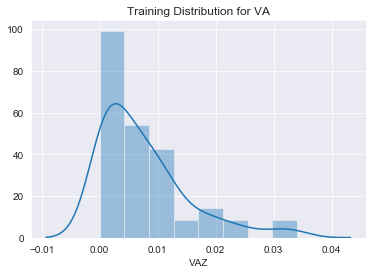

In [110]:
#check out the distribution for VA
sns.distplot(trainDF[target])
plt.title("Training Distribution for VA")

Text(0.5, 1.0, 'Testing Distribution for VA')

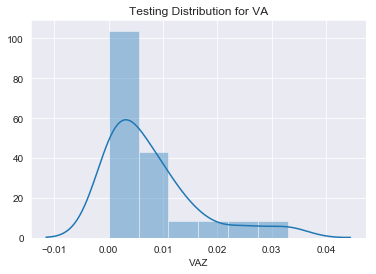

In [111]:
#check out the distribution for VA
sns.distplot(testDF[target])
plt.title("Testing Distribution for VA")

In [112]:
#perform necessary preprocessing on the data
dropColumns = targetColumns + ['key']
trainSpectra = trainDF.drop(dropColumns,axis=1)
testSpectra = testDF.drop(dropColumns,axis=1)
print(trainSpectra.shape,testSpectra.shape)

#scale the data
scaledTrainSpectra = np.transpose(StandardScaler().fit_transform(np.transpose(trainSpectra.values)))
scaledTestSpectra = np.transpose(StandardScaler().fit_transform(np.transpose(testSpectra.values)))

#derivative of the data
dXTrainSpectra = savgol_filter(trainSpectra.values, window_length=25, polyorder=3,deriv=1)
dXTestSpectra = savgol_filter(testSpectra.values, window_length=25, polyorder=3, deriv=1)

ddXTrainSpectra = savgol_filter(trainSpectra.values, window_length=25, polyorder=3,deriv=2)
ddXTestSpectra = savgol_filter(testSpectra.values, window_length=25, polyorder=3, deriv=2)

(83, 46) (21, 46)


# Visualize the training and testing sets

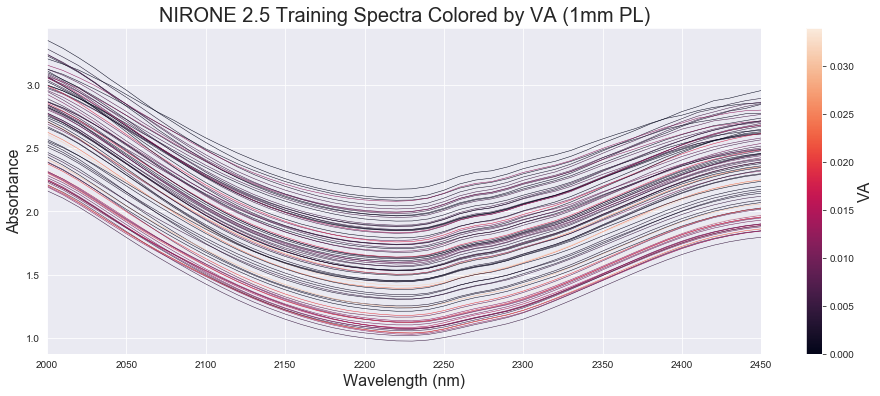

In [114]:
x = wavelengths
y = trainSpectra.values
z = trainDF[target]

ys = [i for i in y] #put into the format for LineCollection

# We need to set the plot limits, they will not autoscale
# fig, ax = plt.subplots(figsize=(8,3)) #for paper
fig, ax = plt.subplots(figsize=(16,6))
ax.set_xlim(np.min(x), np.max(x))
ax.set_ylim(np.min(ys)-.1, np.max(ys)+.1)
# # Make a sequence of x,y pairs
line_segments = LineCollection([np.column_stack([x, y]) for y in ys],
                               array = z,
                               linewidths=0.5,
                               linestyles='solid')

ax.add_collection(line_segments)
axcb = fig.colorbar(line_segments)
axcb.set_label('VA', fontsize=16)
ax.set_title("NIRONE 2.5 Training Spectra Colored by VA (1mm PL)", fontsize=20)
ax.set_ylabel("Absorbance", fontsize = 16)
ax.set_xlabel("Wavelength (nm)", fontsize = 16)
plt.show()

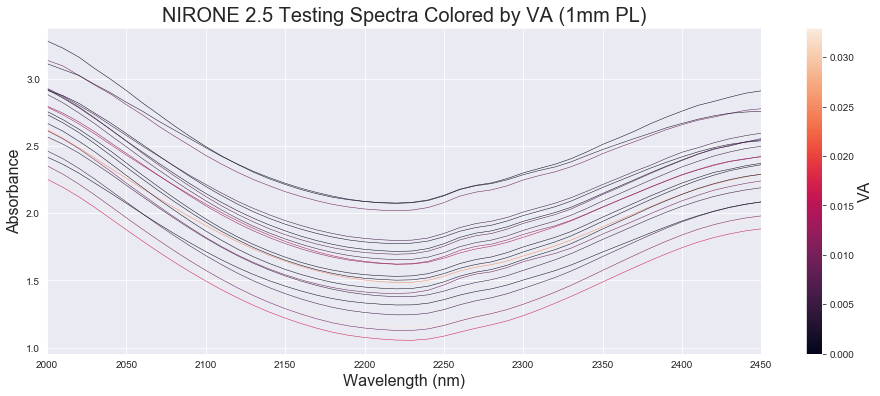

In [115]:
x = wavelengths
y = testSpectra.values
z = testDF[target]

ys = [i for i in y] #put into the format for LineCollection

# We need to set the plot limits, they will not autoscale
# fig, ax = plt.subplots(figsize=(8,3)) #for paper
fig, ax = plt.subplots(figsize=(16,6))
ax.set_xlim(np.min(x), np.max(x))
ax.set_ylim(np.min(ys)-.1, np.max(ys)+.1)
# # Make a sequence of x,y pairs
line_segments = LineCollection([np.column_stack([x, y]) for y in ys],
                               array = z,
                               linewidths=0.5,
                               linestyles='solid')

ax.add_collection(line_segments)
axcb = fig.colorbar(line_segments)
axcb.set_label('VA', fontsize=16)
ax.set_title("NIRONE 2.5 Testing Spectra Colored by VA (1mm PL)", fontsize=20)
ax.set_ylabel("Absorbance", fontsize = 16)
ax.set_xlabel("Wavelength (nm)", fontsize = 16)
plt.show()

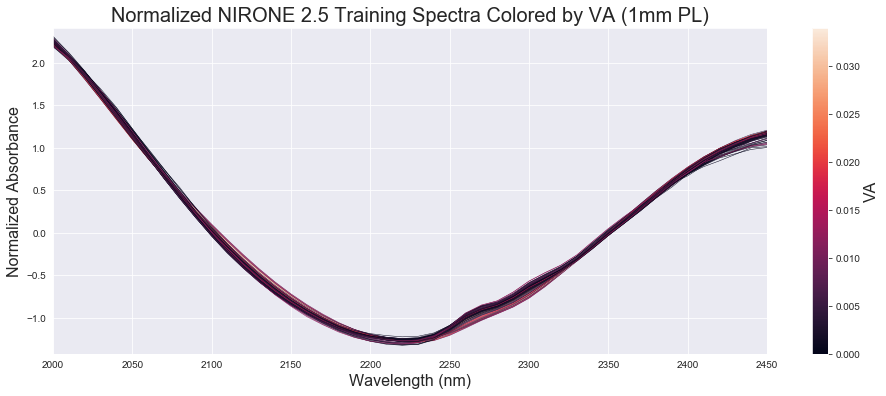

In [116]:
x = wavelengths
y = scaledTrainSpectra
z = trainDF[target]

ys = [i for i in y] #put into the format for LineCollection

# We need to set the plot limits, they will not autoscale
# fig, ax = plt.subplots(figsize=(8,3)) #for paper
fig, ax = plt.subplots(figsize=(16,6))
ax.set_xlim(np.min(x), np.max(x))
ax.set_ylim(np.min(ys)-.1, np.max(ys)+.1)
# # Make a sequence of x,y pairs
line_segments = LineCollection([np.column_stack([x, y]) for y in ys],
                               array = z,
                               linewidths=0.5,
                               linestyles='solid')

ax.add_collection(line_segments)
axcb = fig.colorbar(line_segments)
axcb.set_label('VA', fontsize=16)
ax.set_title("Normalized NIRONE 2.5 Training Spectra Colored by VA (1mm PL)", fontsize=20)
ax.set_ylabel("Normalized Absorbance", fontsize = 16)
ax.set_xlabel("Wavelength (nm)", fontsize = 16)
plt.show()

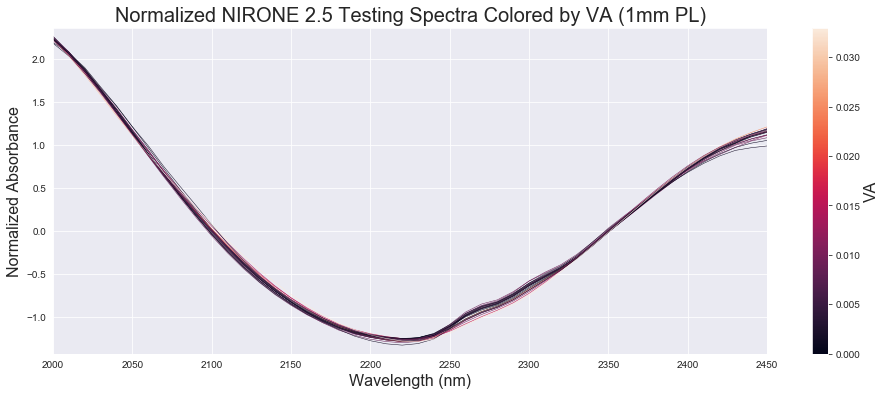

In [117]:
x = wavelengths
y = scaledTestSpectra
z = testDF[target]

ys = [i for i in y] #put into the format for LineCollection

# We need to set the plot limits, they will not autoscale
# fig, ax = plt.subplots(figsize=(8,3)) #for paper
fig, ax = plt.subplots(figsize=(16,6))
ax.set_xlim(np.min(x), np.max(x))
ax.set_ylim(np.min(ys)-.1, np.max(ys)+.1)
# # Make a sequence of x,y pairs
line_segments = LineCollection([np.column_stack([x, y]) for y in ys],
                               array = z,
                               linewidths=0.5,
                               linestyles='solid')

ax.add_collection(line_segments)
axcb = fig.colorbar(line_segments)
axcb.set_label('VA', fontsize=16)
ax.set_title("Normalized NIRONE 2.5 Testing Spectra Colored by VA (1mm PL)", fontsize=20)
ax.set_ylabel("Normalized Absorbance", fontsize = 16)
ax.set_xlabel("Wavelength (nm)", fontsize = 16)
plt.show()

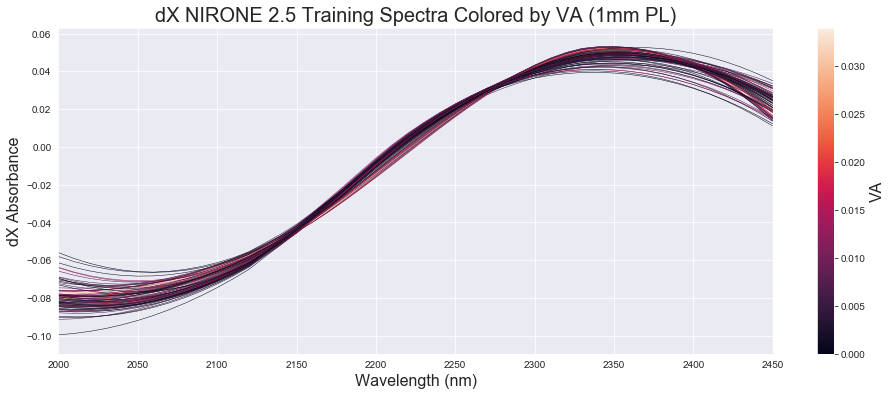

In [118]:
x = wavelengths
y = dXTrainSpectra
z = trainDF[target]

ys = [i for i in y] #put into the format for LineCollection

# We need to set the plot limits, they will not autoscale
# fig, ax = plt.subplots(figsize=(8,3)) #for paper
fig, ax = plt.subplots(figsize=(16,6))
ax.set_xlim(np.min(x), np.max(x))
ax.set_ylim(np.min(ys)-.01, np.max(ys)+.01)
# # Make a sequence of x,y pairs
line_segments = LineCollection([np.column_stack([x, y]) for y in ys],
                               array = z,
                               linewidths=0.5,
                               linestyles='solid')

ax.add_collection(line_segments)
axcb = fig.colorbar(line_segments)
axcb.set_label('VA', fontsize=16)
ax.set_title("dX NIRONE 2.5 Training Spectra Colored by VA (1mm PL)", fontsize=20)
ax.set_ylabel("dX Absorbance", fontsize = 16)
ax.set_xlabel("Wavelength (nm)", fontsize = 16)
plt.show()

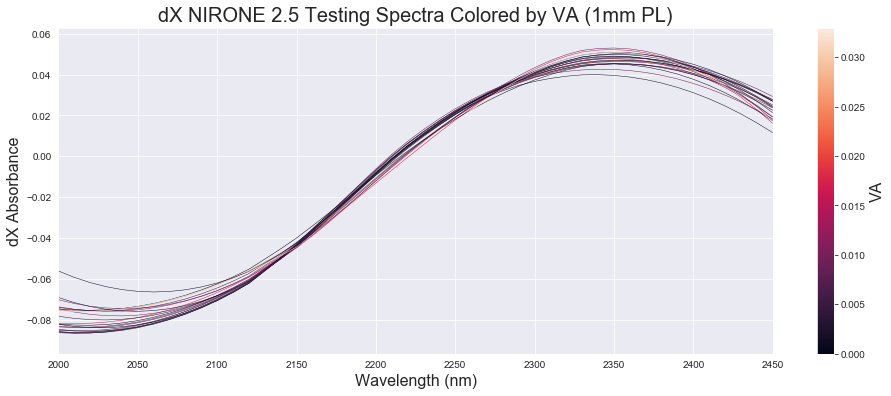

In [119]:
x = wavelengths
y = dXTestSpectra
z = testDF[target]

ys = [i for i in y] #put into the format for LineCollection

# We need to set the plot limits, they will not autoscale
# fig, ax = plt.subplots(figsize=(8,3)) #for paper
fig, ax = plt.subplots(figsize=(16,6))
ax.set_xlim(np.min(x), np.max(x))
ax.set_ylim(np.min(ys)-.01, np.max(ys)+.01)
# # Make a sequence of x,y pairs
line_segments = LineCollection([np.column_stack([x, y]) for y in ys],
                               array = z,
                               linewidths=0.5,
                               linestyles='solid')

ax.add_collection(line_segments)
axcb = fig.colorbar(line_segments)
axcb.set_label('VA', fontsize=16)
ax.set_title("dX NIRONE 2.5 Testing Spectra Colored by VA (1mm PL)", fontsize=20)
ax.set_ylabel("dX Absorbance", fontsize = 16)
ax.set_xlabel("Wavelength (nm)", fontsize = 16)
plt.show()

# PLS

optimal number of components = 2


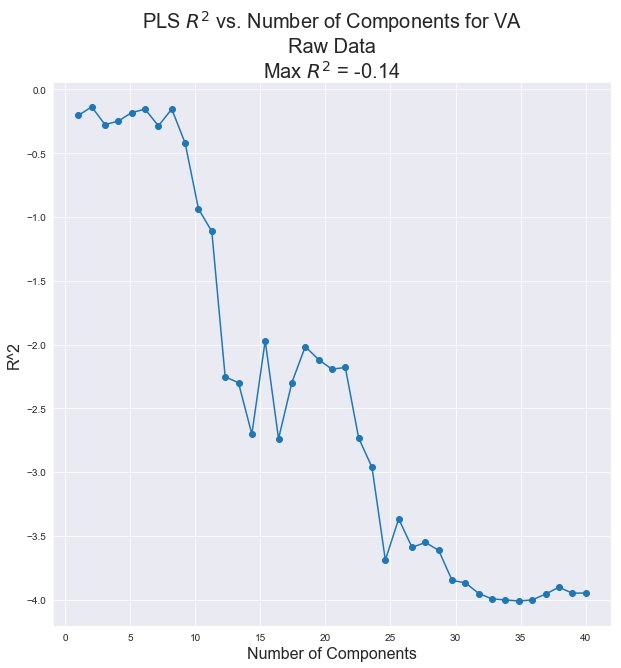

In [120]:
r2List =[]
for i in range(1,40):
    PLS = PLSRegression(n_components=i)
    X = trainSpectra
    y = trainDF[target]

#     print(X.shape,y.shape)
#     print()
    scores = cross_val_score(PLS,X,y,cv=9)
    medianR2 = np.median(scores)
    r2List.append(medianR2)
#     print(scores)
#     print("Median: {}".format(medianR2))
fig,ax = plt.subplots(figsize=(10,10))
ax.plot(np.linspace(1,40,39),r2List, marker='o')
ax.set_xlabel("Number of Components", fontsize = 16)
ax.set_ylabel("R^2", fontsize = 16)
ax.set_title("PLS $R^2$ vs. Number of Components for VA \nRaw Data\nMax $R^2$ = {}".format(np.round(np.max(r2List),2)), fontsize = 20)

print("optimal number of components = "+ str(np.where(r2List == np.amax(r2List))[0][0]+1))

optimal number of components = 4


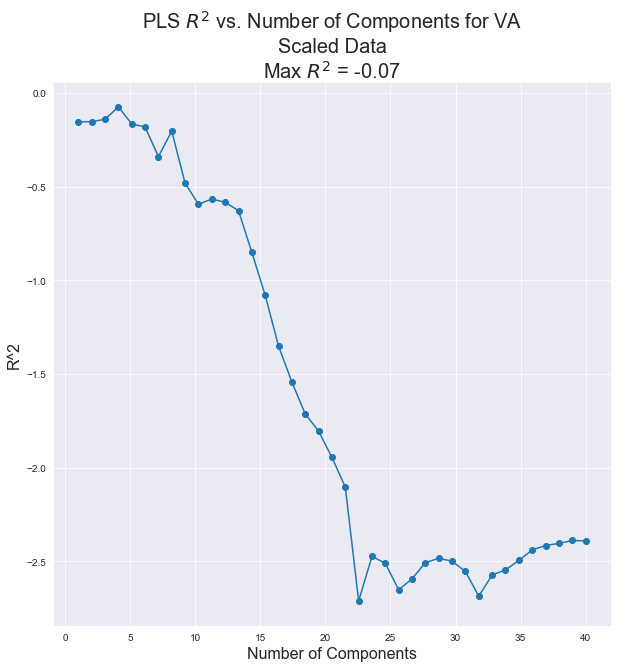

In [121]:
r2List =[]
for i in range(1,40):
    PLS = PLSRegression(n_components=i)
    X = scaledTrainSpectra
    y = trainDF[target]

#     print(X.shape,y.shape)
#     print()
    scores = cross_val_score(PLS,X,y,cv=9)
    medianR2 = np.median(scores)
    r2List.append(medianR2)
#     print(scores)
#     print("Median: {}".format(medianR2))
fig,ax = plt.subplots(figsize=(10,10))
ax.plot(np.linspace(1,40,39),r2List, marker='o')
ax.set_xlabel("Number of Components", fontsize = 16)
ax.set_ylabel("R^2", fontsize = 16)
ax.set_title("PLS $R^2$ vs. Number of Components for VA \nScaled Data\nMax $R^2$ = {}".format(np.round(np.max(r2List),2)), fontsize = 20)

print("optimal number of components = "+ str(np.where(r2List == np.amax(r2List))[0][0]+1))

optimal number of components = 8


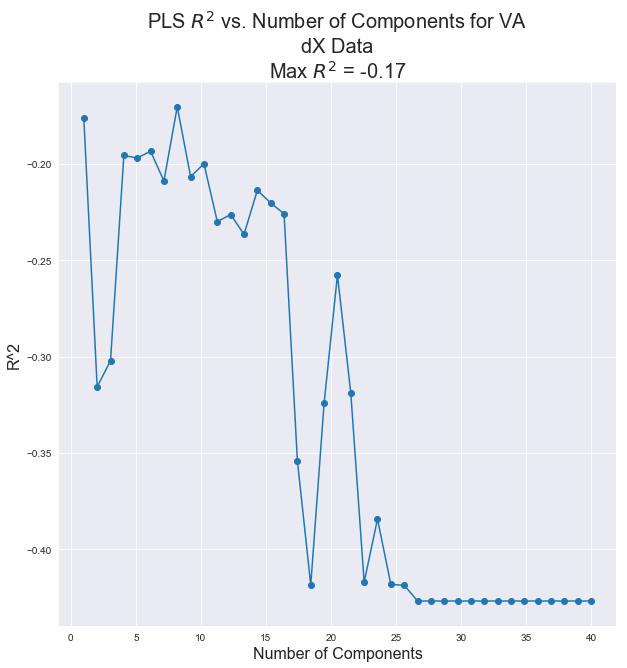

In [122]:
r2List =[]
for i in range(1,40):
    PLS = PLSRegression(n_components=i)
    X = dXTrainSpectra
    y = trainDF[target]

#     print(X.shape,y.shape)
#     print()
    scores = cross_val_score(PLS,X,y,cv=9)
    medianR2 = np.median(scores)
    r2List.append(medianR2)
#     print(scores)
#     print("Median: {}".format(medianR2))
fig,ax = plt.subplots(figsize=(10,10))
ax.plot(np.linspace(1,40,39),r2List, marker='o')
ax.set_xlabel("Number of Components", fontsize = 16)
ax.set_ylabel("R^2", fontsize = 16)
ax.set_title("PLS $R^2$ vs. Number of Components for VA \ndX Data\nMax $R^2$ = {}".format(np.round(np.max(r2List),2)), fontsize = 20)

print("optimal number of components = "+ str(np.where(r2List == np.amax(r2List))[0][0]+1))

optimal number of components = 10


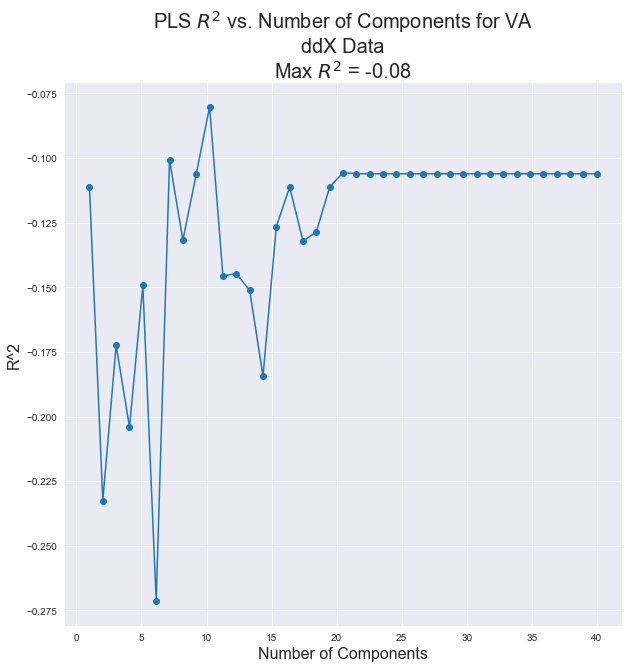

In [123]:
r2List =[]
for i in range(1,40):
    PLS = PLSRegression(n_components=i)
    X = ddXTrainSpectra
    y = trainDF[target]

#     print(X.shape,y.shape)
#     print()
    scores = cross_val_score(PLS,X,y,cv=9)
    medianR2 = np.median(scores)
    r2List.append(medianR2)
#     print(scores)
#     print("Median: {}".format(medianR2))
fig,ax = plt.subplots(figsize=(10,10))
ax.plot(np.linspace(1,40,39),r2List, marker='o')
ax.set_xlabel("Number of Components", fontsize = 16)
ax.set_ylabel("R^2", fontsize = 16)
ax.set_title("PLS $R^2$ vs. Number of Components for VA \nddX Data\nMax $R^2$ = {}".format(np.round(np.max(r2List),2)), fontsize = 20)

print("optimal number of components = "+ str(np.where(r2List == np.amax(r2List))[0][0]+1))

In [124]:
model = PLSRegression(n_components=8)
X = trainSpectra
y = trainDF[target]

model.fit(X,y)
pred = model.predict(testSpectra)
r2 = r2_score(y_true=testDF[target], y_pred=pred)
rmsep = np.sqrt(mean_squared_error(y_true=testDF[target], y_pred=pred))
r2, rmsep

(0.27046765729043354, 0.007175936539865708)

# Try SVR

In [125]:
# gsc = GridSearchCV(
#         estimator=SVR(kernel='rbf'),
#         param_grid={
#             'C': [0.1, 1, 100, 1000,10000,100000],
#             'epsilon': [0.0001, 0.0005, 0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1, 5, 10],
#             'gamma': [0.0001, 0.001, 0.005, 0.1, 1, 3, 5]
#         },
#         cv=9, scoring='neg_mean_squared_error', verbose=0, n_jobs=-1)
# grid_result = gsc.fit(scaledTrainSpectra, trainDF[target])
# best_params = grid_result.best_params_
# best_params

{'C': 100, 'epsilon': 0.0001, 'gamma': 0.001}

In [126]:
# model = SVR(kernel='rbf',
#             C=best_params['C'],
#             epsilon=best_params['epsilon'],
#             gamma=best_params['gamma'])

# X = scaledTrainSpectra
# y = trainDF[target]

# model.fit(X,y)
# pred = model.predict(scaledTestSpectra)
# r2 = r2_score(y_true=testDF[target], y_pred=pred)
# rmsep = np.sqrt(mean_squared_error(y_true=testDF[target], y_pred=pred))
# r2, rmsep

(0.2874202420491465, 0.007092070674518659)

In [127]:

# gsc = GridSearchCV(
#         estimator=SVR(kernel='linear'),
#         param_grid={
#             'C': [0.1, 1, 100, 1000,10000,100000]
#         },
#         cv=9, scoring='neg_mean_squared_error', verbose=0, n_jobs=-1)

# grid_result = gsc.fit(scaledTrainSpectra, trainDF[target])
# best_params = grid_result.best_params_
# best_params

{'C': 0.1}

In [128]:
# model = SVR(kernel='linear',
#            C = best_params['C'],
#            gamma='auto')
# X = scaledTrainSpectra
# y = trainDF[target]

# model.fit(X,y)
# pred = model.predict(scaledTestSpectra)
# r2 = r2_score(y_true=testDF[target], y_pred=pred)
# rmsep = np.sqrt(mean_squared_error(y_true=testDF[target], y_pred=pred))
# r2, rmsep

(-1.2215690053970647, 0.012522360951894131)

In [133]:
gsc = GridSearchCV(
        estimator=SVR(kernel='rbf'),
        param_grid={
            'C': [0.1, 1, 100, 1000,10000,100000],
            'epsilon': [0.0001, 0.0005, 0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1, 5, 10],
            'gamma': [0.0001, 0.001, 0.005, 0.1, 1, 3, 5]
        },
        cv=9, scoring='neg_mean_squared_error', verbose=0, n_jobs=-1)
grid_result = gsc.fit(dXTrainSpectra, trainDF[target])
best_params = grid_result.best_params_
best_params

{'C': 10000, 'epsilon': 0.001, 'gamma': 0.1}

In [134]:
model = SVR(kernel='rbf',
            C=best_params['C'],
            epsilon=best_params['epsilon'],
            gamma=best_params['gamma'])

X = dXTrainSpectra
y = trainDF[target]

model.fit(X,y)
pred = model.predict(dXTestSpectra)
r2 = r2_score(y_true=testDF[target], y_pred=pred)
rmsep = np.sqrt(mean_squared_error(y_true=testDF[target], y_pred=pred))
r2, rmsep

(0.31713102315606656, 0.006942645746209785)

In [131]:
# gsc = GridSearchCV(
#         estimator=SVR(kernel='rbf'),
#         param_grid={
#             'C': [0.1, 1, 100, 1000,10000,100000],
#             'epsilon': [0.0001, 0.0005, 0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1, 5, 10],
#             'gamma': [0.0001, 0.001, 0.005, 0.1, 1, 3, 5]
#         },
#         cv=9, scoring='neg_mean_squared_error', verbose=0, n_jobs=-1)
# grid_result = gsc.fit(ddXTrainSpectra, trainDF[target])
# best_params = grid_result.best_params_
# best_params

{'C': 10000, 'epsilon': 0.0005, 'gamma': 5}

In [132]:
# model = SVR(kernel='rbf',
#             C=best_params['C'],
#             epsilon=best_params['epsilon'],
#             gamma=best_params['gamma'])

# X = ddXTrainSpectra
# y = trainDF[target]

# model.fit(X,y)
# pred = model.predict(ddXTestSpectra)
# r2 = r2_score(y_true=testDF[target], y_pred=pred)
# rmsep = np.sqrt(mean_squared_error(y_true=testDF[target], y_pred=pred))
# r2, rmsep

(0.2777498976762075, 0.007140031375201003)

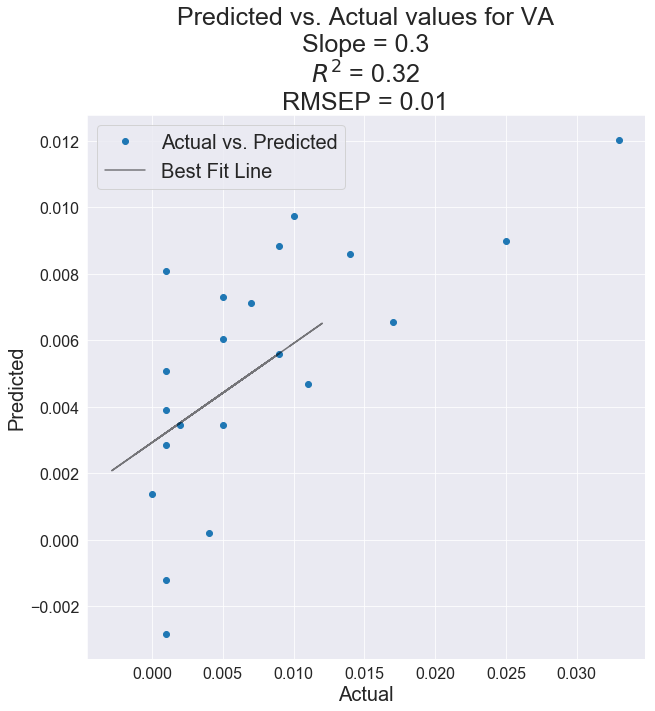

In [135]:
slope,intercept = np.polyfit(testDF[target],pred.reshape(pred.shape[0]),1)
f = np.poly1d([slope,intercept]) 
fig,ax = plt.subplots(figsize = (10,10))
plt.plot(testDF[target],pred,'o', label="Actual vs. Predicted")
plt.plot(pred,f(pred), 'k-',label="Best Fit Line", alpha=0.5)
ax.set_xlabel("Actual", fontsize = 20)
ax.set_ylabel("Predicted", fontsize = 20)
ax.set_title("Predicted vs. Actual values for VA\nSlope = {}\n$R^2$ = {}\nRMSEP = {}".format(np.round(slope,2),np.round(r2,2), np.round(rmsep,2)), fontsize=25);
ax.legend(prop={"size":20});
for tick in ax.xaxis.get_major_ticks():
    tick.label.set_fontsize(16) 
    
for tick in ax.yaxis.get_major_ticks():
    tick.label.set_fontsize(16) 

# Random Forest

In [140]:
model = RandomForestRegressor(n_estimators=100, max_features='sqrt')
X = scaledTrainSpectra
y = trainDF[target]

model.fit(X,y)
pred = model.predict(scaledTestSpectra)
r2 = r2_score(y_true=testDF[target], y_pred=pred)
rmsep = np.sqrt(mean_squared_error(y_true=testDF[target], y_pred=pred))
r2, rmsep

(0.39235040814978017, 0.006549119567476309)

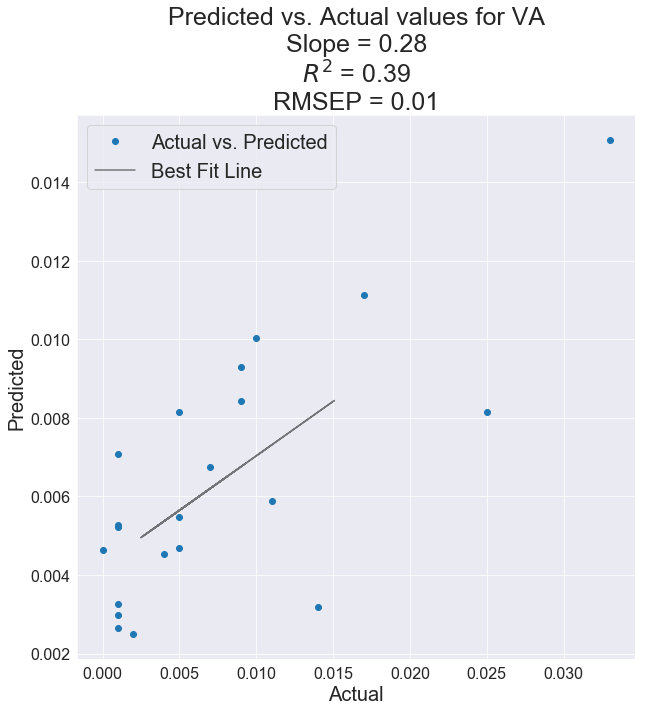

In [141]:
slope,intercept = np.polyfit(testDF[target],pred.reshape(pred.shape[0]),1)
f = np.poly1d([slope,intercept]) 
fig,ax = plt.subplots(figsize = (10,10))
plt.plot(testDF[target],pred,'o', label="Actual vs. Predicted")
plt.plot(pred,f(pred), 'k-',label="Best Fit Line", alpha=0.5)
ax.set_xlabel("Actual", fontsize = 20)
ax.set_ylabel("Predicted", fontsize = 20)
ax.set_title("Predicted vs. Actual values for VA\nSlope = {}\n$R^2$ = {}\nRMSEP = {}".format(np.round(slope,2),np.round(r2,2), np.round(rmsep,2)), fontsize=25);
ax.legend(prop={"size":20});
for tick in ax.xaxis.get_major_ticks():
    tick.label.set_fontsize(16) 
    
for tick in ax.yaxis.get_major_ticks():
    tick.label.set_fontsize(16) 

# yeast count

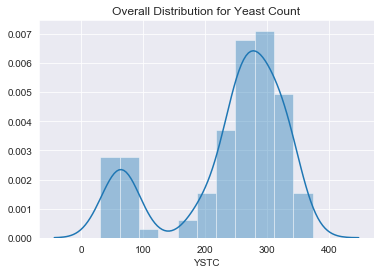

In [142]:
target = 'YSTC'
#check out the distribution for yeast count
sns.distplot(meanDF[target])
plt.title("Overall Distribution for Yeast Count");

In [143]:
#Divide into categories
meanDF['YSTS_categories'] = np.ceil(meanDF[target]/30)
meanDF.YSTS_categories.value_counts().sort_index()

2.0      8
3.0     10
4.0      1
6.0      1
7.0      4
8.0      7
9.0     23
10.0    23
11.0    15
12.0    11
13.0     1
Name: YSTS_categories, dtype: int64

In [144]:
#merget the categories to keep bimodal
meanDF['YSTS_categories'].where((meanDF['YSTS_categories']<3) | (meanDF['YSTS_categories']>6),3.0, inplace=True)
meanDF['YSTS_categories'].where((meanDF["YSTS_categories"]<4) | (meanDF['YSTS_categories']>9),9.0,inplace=True)
meanDF['YSTS_categories'].where(meanDF['YSTS_categories']<12,12.0,inplace=True)
meanDF.YSTS_categories.value_counts().sort_index()

2.0      8
3.0     12
9.0     34
10.0    23
11.0    15
12.0    12
Name: YSTS_categories, dtype: int64

In [145]:
split = StratifiedShuffleSplit(n_splits=1,test_size=0.2, random_state=42)

for train_index, test_index in split.split(meanDF,meanDF["YSTS_categories"]):
    trainDF = meanDF.reset_index().loc[train_index]
    testDF = meanDF.reset_index().loc[test_index]
#get rid of the *_categories
meanDF = meanDF.drop("YSTS_categories", axis=1)
trainDF = trainDF.drop("YSTS_categories", axis=1)
testDF = testDF.drop("YSTS_categories", axis=1)

In [146]:
trainDF = trainDF.reset_index(drop=True)
testDF = testDF.reset_index(drop=True)
trainDF.shape, testDF.shape

((83, 55), (21, 55))

Text(0.5, 1.0, 'Training Distribution for Yeast Count')

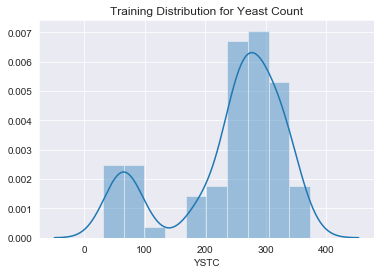

In [147]:
#check out the distribution for yeast count
sns.distplot(trainDF[target])
plt.title("Training Distribution for Yeast Count")

Text(0.5, 1.0, 'Testing Distribution for Yeast Count')

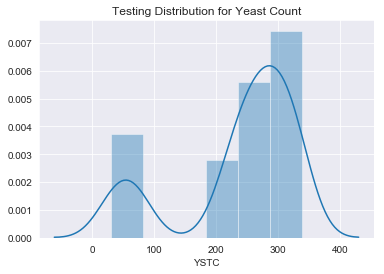

In [148]:
#check out the distribution for yeast count
sns.distplot(testDF[target])
plt.title("Testing Distribution for Yeast Count")

In [149]:
#perform necessary preprocessing on the data
dropColumns = targetColumns + ['key']
trainSpectra = trainDF.drop(dropColumns,axis=1)
testSpectra = testDF.drop(dropColumns,axis=1)
print(trainSpectra.shape,testSpectra.shape)

#scale the data
scaledTrainSpectra = np.transpose(StandardScaler().fit_transform(np.transpose(trainSpectra.values)))
scaledTestSpectra = np.transpose(StandardScaler().fit_transform(np.transpose(testSpectra.values)))

#derivative of the data
dXTrainSpectra = savgol_filter(trainSpectra.values, window_length=25, polyorder=3,deriv=1)
dXTestSpectra = savgol_filter(testSpectra.values, window_length=25, polyorder=3, deriv=1)

ddXTrainSpectra = savgol_filter(trainSpectra.values, window_length=25, polyorder=3,deriv=2)
ddXTestSpectra = savgol_filter(testSpectra.values, window_length=25, polyorder=3, deriv=2)

(83, 46) (21, 46)


# Visualize the training and testing set

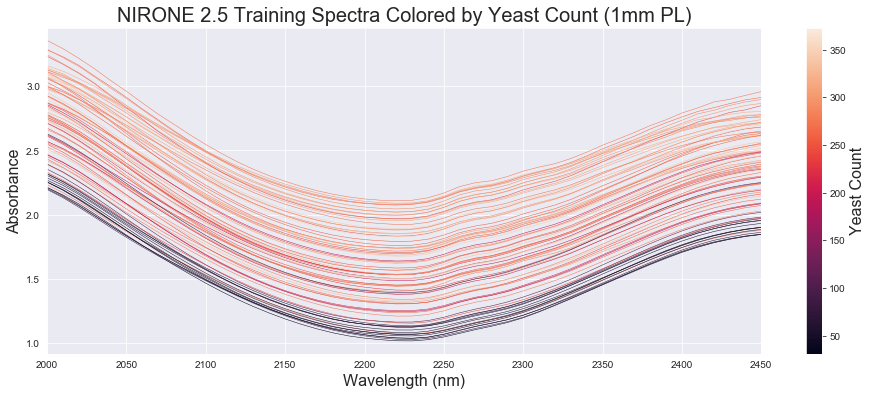

In [150]:
x = wavelengths
y = trainSpectra.values
z = trainDF[target]

ys = [i for i in y] #put into the format for LineCollection

# We need to set the plot limits, they will not autoscale
# fig, ax = plt.subplots(figsize=(8,3)) #for paper
fig, ax = plt.subplots(figsize=(16,6))
ax.set_xlim(np.min(x), np.max(x))
ax.set_ylim(np.min(ys)-.1, np.max(ys)+.1)
# # Make a sequence of x,y pairs
line_segments = LineCollection([np.column_stack([x, y]) for y in ys],
                               array = z,
                               linewidths=0.5,
                               linestyles='solid')

ax.add_collection(line_segments)
axcb = fig.colorbar(line_segments)
axcb.set_label('Yeast Count', fontsize=16)
ax.set_title("NIRONE 2.5 Training Spectra Colored by Yeast Count (1mm PL)", fontsize=20)
ax.set_ylabel("Absorbance", fontsize = 16)
ax.set_xlabel("Wavelength (nm)", fontsize = 16)
plt.show()

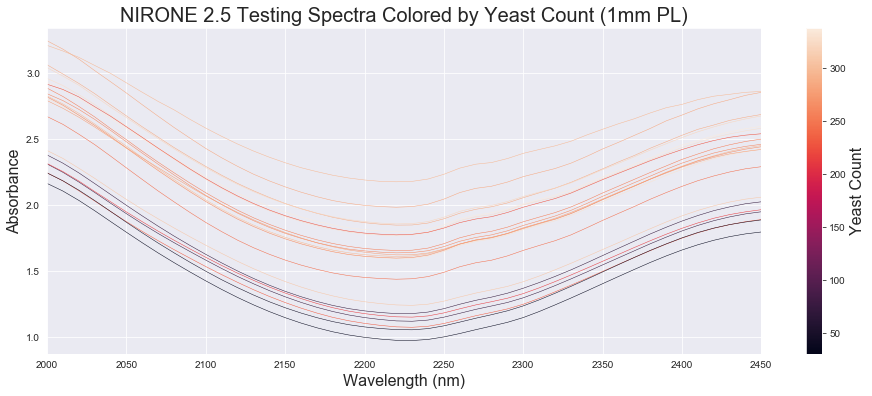

In [151]:
x = wavelengths
y = testSpectra.values
z = testDF[target]

ys = [i for i in y] #put into the format for LineCollection

# We need to set the plot limits, they will not autoscale
# fig, ax = plt.subplots(figsize=(8,3)) #for paper
fig, ax = plt.subplots(figsize=(16,6))
ax.set_xlim(np.min(x), np.max(x))
ax.set_ylim(np.min(ys)-.1, np.max(ys)+.1)
# # Make a sequence of x,y pairs
line_segments = LineCollection([np.column_stack([x, y]) for y in ys],
                               array = z,
                               linewidths=0.5,
                               linestyles='solid')

ax.add_collection(line_segments)
axcb = fig.colorbar(line_segments)
axcb.set_label('Yeast Count', fontsize=16)
ax.set_title("NIRONE 2.5 Testing Spectra Colored by Yeast Count (1mm PL)", fontsize=20)
ax.set_ylabel("Absorbance", fontsize = 16)
ax.set_xlabel("Wavelength (nm)", fontsize = 16)
plt.show()

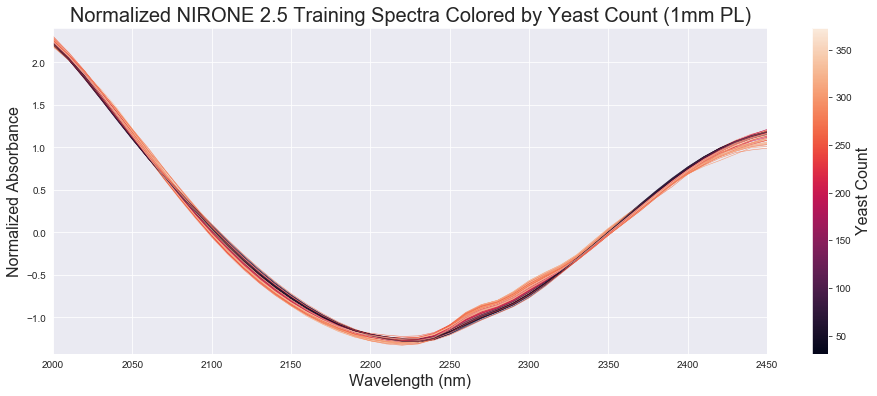

In [152]:
x = wavelengths
y = scaledTrainSpectra
z = trainDF[target]

ys = [i for i in y] #put into the format for LineCollection

# We need to set the plot limits, they will not autoscale
# fig, ax = plt.subplots(figsize=(8,3)) #for paper
fig, ax = plt.subplots(figsize=(16,6))
ax.set_xlim(np.min(x), np.max(x))
ax.set_ylim(np.min(ys)-.1, np.max(ys)+.1)
# # Make a sequence of x,y pairs
line_segments = LineCollection([np.column_stack([x, y]) for y in ys],
                               array = z,
                               linewidths=0.5,
                               linestyles='solid')

ax.add_collection(line_segments)
axcb = fig.colorbar(line_segments)
axcb.set_label('Yeast Count', fontsize=16)
ax.set_title("Normalized NIRONE 2.5 Training Spectra Colored by Yeast Count (1mm PL)", fontsize=20)
ax.set_ylabel("Normalized Absorbance", fontsize = 16)
ax.set_xlabel("Wavelength (nm)", fontsize = 16)
plt.show()

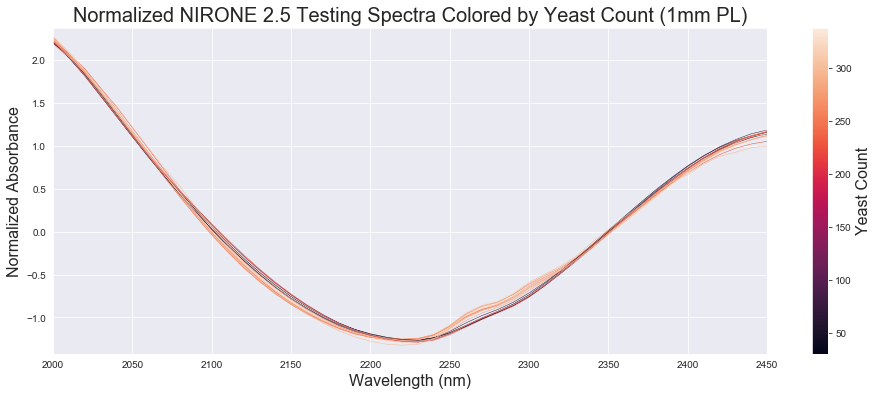

In [153]:
x = wavelengths
y = scaledTestSpectra
z = testDF[target]

ys = [i for i in y] #put into the format for LineCollection

# We need to set the plot limits, they will not autoscale
# fig, ax = plt.subplots(figsize=(8,3)) #for paper
fig, ax = plt.subplots(figsize=(16,6))
ax.set_xlim(np.min(x), np.max(x))
ax.set_ylim(np.min(ys)-.1, np.max(ys)+.1)
# # Make a sequence of x,y pairs
line_segments = LineCollection([np.column_stack([x, y]) for y in ys],
                               array = z,
                               linewidths=0.5,
                               linestyles='solid')

ax.add_collection(line_segments)
axcb = fig.colorbar(line_segments)
axcb.set_label('Yeast Count', fontsize=16)
ax.set_title("Normalized NIRONE 2.5 Testing Spectra Colored by Yeast Count (1mm PL)", fontsize=20)
ax.set_ylabel("Normalized Absorbance", fontsize = 16)
ax.set_xlabel("Wavelength (nm)", fontsize = 16)
plt.show()

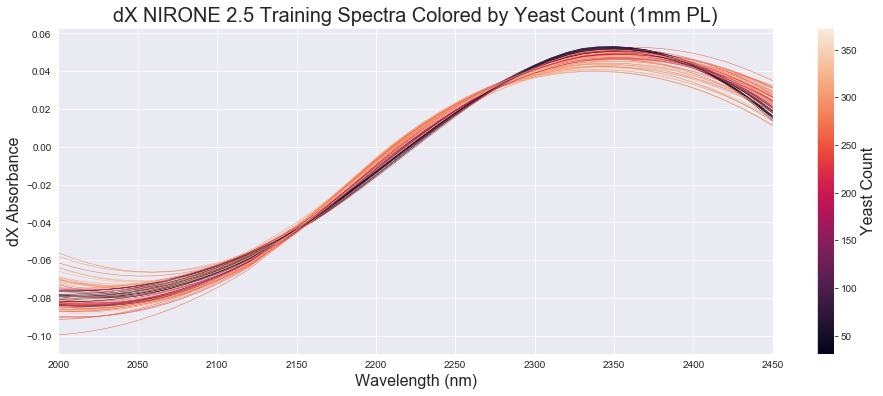

In [154]:
x = wavelengths
y = dXTrainSpectra
z = trainDF[target]

ys = [i for i in y] #put into the format for LineCollection

# We need to set the plot limits, they will not autoscale
# fig, ax = plt.subplots(figsize=(8,3)) #for paper
fig, ax = plt.subplots(figsize=(16,6))
ax.set_xlim(np.min(x), np.max(x))
ax.set_ylim(np.min(ys)-.01, np.max(ys)+.01)
# # Make a sequence of x,y pairs
line_segments = LineCollection([np.column_stack([x, y]) for y in ys],
                               array = z,
                               linewidths=0.5,
                               linestyles='solid')

ax.add_collection(line_segments)
axcb = fig.colorbar(line_segments)
axcb.set_label('Yeast Count', fontsize=16)
ax.set_title("dX NIRONE 2.5 Training Spectra Colored by Yeast Count (1mm PL)", fontsize=20)
ax.set_ylabel("dX Absorbance", fontsize = 16)
ax.set_xlabel("Wavelength (nm)", fontsize = 16)
plt.show()

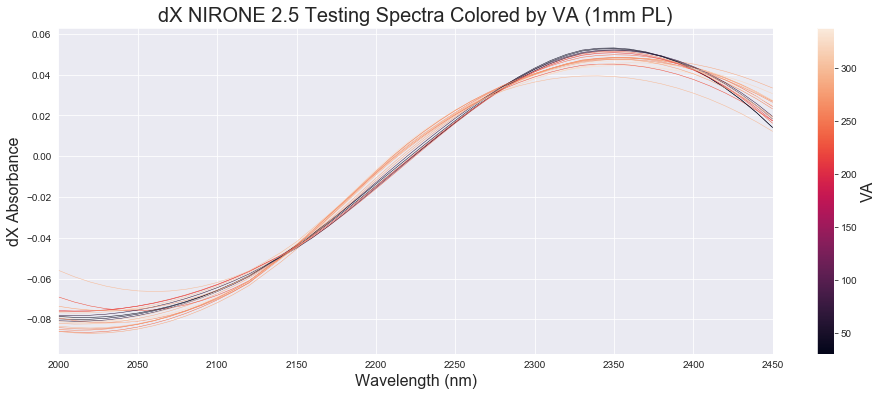

In [155]:
x = wavelengths
y = dXTestSpectra
z = testDF[target]

ys = [i for i in y] #put into the format for LineCollection

# We need to set the plot limits, they will not autoscale
# fig, ax = plt.subplots(figsize=(8,3)) #for paper
fig, ax = plt.subplots(figsize=(16,6))
ax.set_xlim(np.min(x), np.max(x))
ax.set_ylim(np.min(ys)-.01, np.max(ys)+.01)
# # Make a sequence of x,y pairs
line_segments = LineCollection([np.column_stack([x, y]) for y in ys],
                               array = z,
                               linewidths=0.5,
                               linestyles='solid')

ax.add_collection(line_segments)
axcb = fig.colorbar(line_segments)
axcb.set_label('VA', fontsize=16)
ax.set_title("dX NIRONE 2.5 Testing Spectra Colored by VA (1mm PL)", fontsize=20)
ax.set_ylabel("dX Absorbance", fontsize = 16)
ax.set_xlabel("Wavelength (nm)", fontsize = 16)
plt.show()

# PLS

optimal number of components = 7


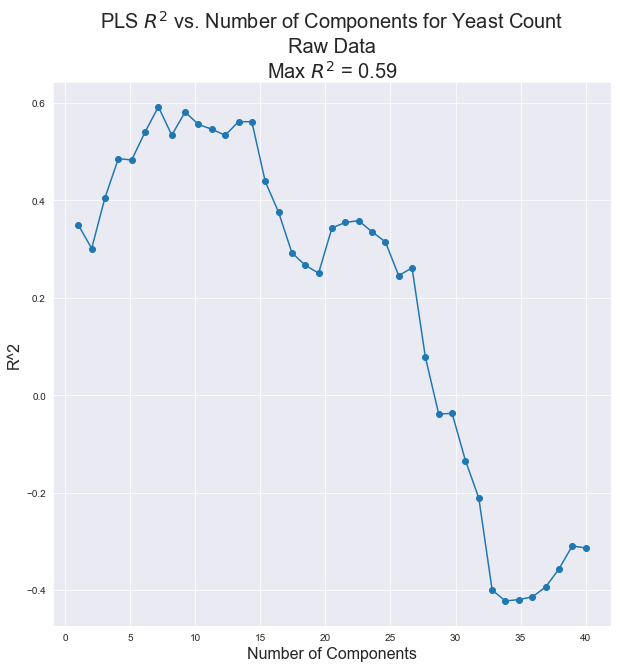

In [156]:
r2List =[]
for i in range(1,40):
    PLS = PLSRegression(n_components=i)
    X = trainSpectra
    y = trainDF[target]

#     print(X.shape,y.shape)
#     print()
    scores = cross_val_score(PLS,X,y,cv=9)
    medianR2 = np.median(scores)
    r2List.append(medianR2)
#     print(scores)
#     print("Median: {}".format(medianR2))
fig,ax = plt.subplots(figsize=(10,10))
ax.plot(np.linspace(1,40,39),r2List, marker='o')
ax.set_xlabel("Number of Components", fontsize = 16)
ax.set_ylabel("R^2", fontsize = 16)
ax.set_title("PLS $R^2$ vs. Number of Components for Yeast Count \nRaw Data\nMax $R^2$ = {}".format(np.round(np.max(r2List),2)), fontsize = 20)

print("optimal number of components = "+ str(np.where(r2List == np.amax(r2List))[0][0]+1))

optimal number of components = 5


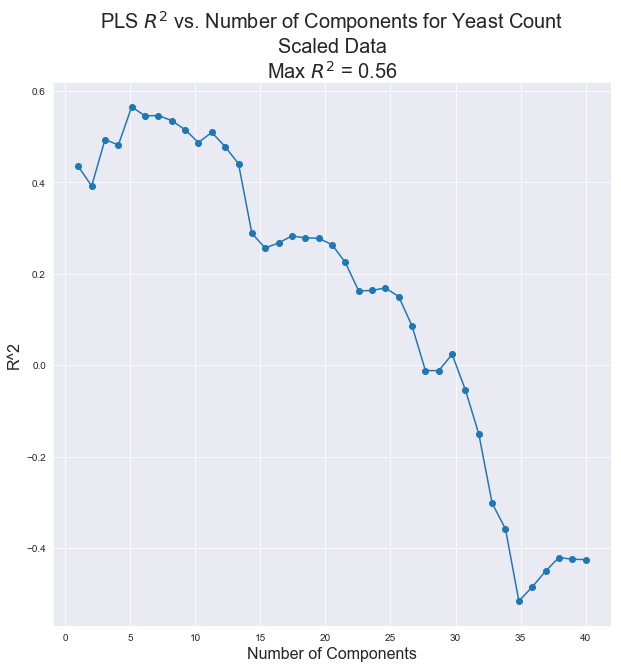

In [157]:
r2List =[]
for i in range(1,40):
    PLS = PLSRegression(n_components=i)
    X = scaledTrainSpectra
    y = trainDF[target]

#     print(X.shape,y.shape)
#     print()
    scores = cross_val_score(PLS,X,y,cv=9)
    medianR2 = np.median(scores)
    r2List.append(medianR2)
#     print(scores)
#     print("Median: {}".format(medianR2))
fig,ax = plt.subplots(figsize=(10,10))
ax.plot(np.linspace(1,40,39),r2List, marker='o')
ax.set_xlabel("Number of Components", fontsize = 16)
ax.set_ylabel("R^2", fontsize = 16)
ax.set_title("PLS $R^2$ vs. Number of Components for Yeast Count \nScaled Data\nMax $R^2$ = {}".format(np.round(np.max(r2List),2)), fontsize = 20)

print("optimal number of components = "+ str(np.where(r2List == np.amax(r2List))[0][0]+1))

optimal number of components = 8


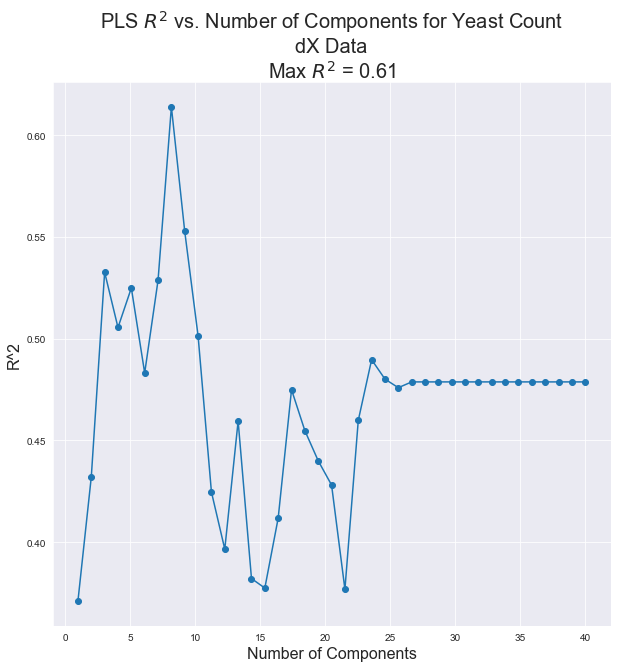

In [158]:
r2List =[]
for i in range(1,40):
    PLS = PLSRegression(n_components=i)
    X = dXTrainSpectra
    y = trainDF[target]

#     print(X.shape,y.shape)
#     print()
    scores = cross_val_score(PLS,X,y,cv=9)
    medianR2 = np.median(scores)
    r2List.append(medianR2)
#     print(scores)
#     print("Median: {}".format(medianR2))
fig,ax = plt.subplots(figsize=(10,10))
ax.plot(np.linspace(1,40,39),r2List, marker='o')
ax.set_xlabel("Number of Components", fontsize = 16)
ax.set_ylabel("R^2", fontsize = 16)
ax.set_title("PLS $R^2$ vs. Number of Components for Yeast Count \ndX Data\nMax $R^2$ = {}".format(np.round(np.max(r2List),2)), fontsize = 20)

print("optimal number of components = "+ str(np.where(r2List == np.amax(r2List))[0][0]+1))

optimal number of components = 3


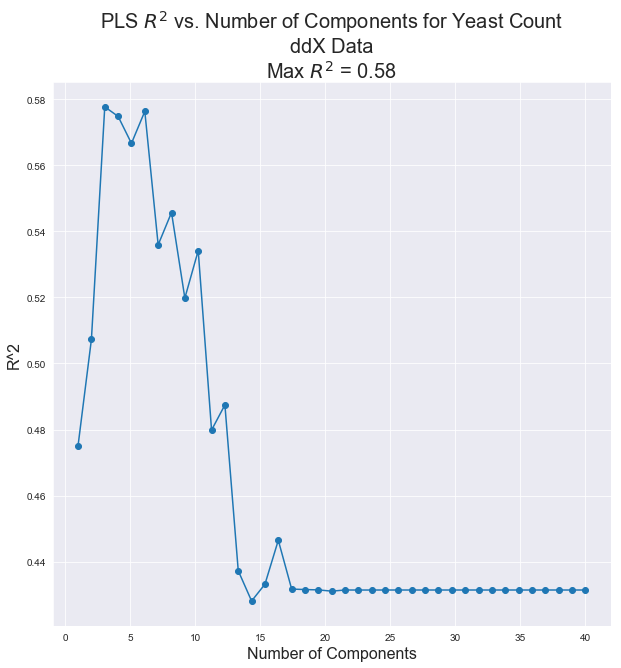

In [159]:
r2List =[]
for i in range(1,40):
    PLS = PLSRegression(n_components=i)
    X = ddXTrainSpectra
    y = trainDF[target]

#     print(X.shape,y.shape)
#     print()
    scores = cross_val_score(PLS,X,y,cv=9)
    medianR2 = np.median(scores)
    r2List.append(medianR2)
#     print(scores)
#     print("Median: {}".format(medianR2))
fig,ax = plt.subplots(figsize=(10,10))
ax.plot(np.linspace(1,40,39),r2List, marker='o')
ax.set_xlabel("Number of Components", fontsize = 16)
ax.set_ylabel("R^2", fontsize = 16)
ax.set_title("PLS $R^2$ vs. Number of Components for Yeast Count \nddX Data\nMax $R^2$ = {}".format(np.round(np.max(r2List),2)), fontsize = 20)

print("optimal number of components = "+ str(np.where(r2List == np.amax(r2List))[0][0]+1))

# for this analysis we are using raw data with 7 components

In [160]:
model = PLSRegression(n_components=7)
X = trainSpectra
y = trainDF[target]

model.fit(X,y)
pred = model.predict(testSpectra)
r2 = r2_score(y_true=testDF[target], y_pred=pred)
rmsep = np.sqrt(mean_squared_error(y_true=testDF[target], y_pred=pred))
r2, rmsep

(0.6306349057895518, 58.06900500637069)

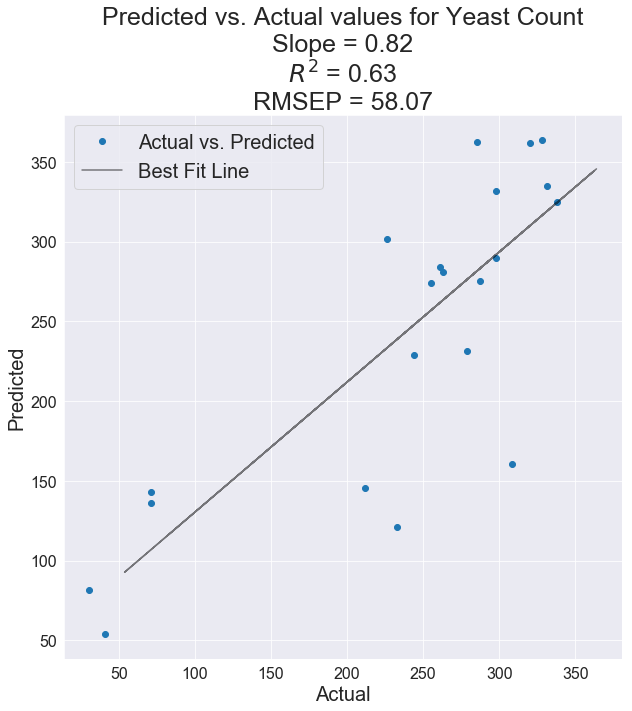

In [161]:
slope,intercept = np.polyfit(testDF[target],pred.reshape(pred.shape[0]),1)
f = np.poly1d([slope,intercept]) 
fig,ax = plt.subplots(figsize = (10,10))
plt.plot(testDF[target],pred,'o', label="Actual vs. Predicted")
plt.plot(pred,f(pred), 'k-',label="Best Fit Line", alpha=0.5)
ax.set_xlabel("Actual", fontsize = 20)
ax.set_ylabel("Predicted", fontsize = 20)
ax.set_title("Predicted vs. Actual values for Yeast Count\nSlope = {}\n$R^2$ = {}\nRMSEP = {}".format(np.round(slope,2),np.round(r2,2), np.round(rmsep,2)), fontsize=25);
ax.legend(prop={"size":20});
for tick in ax.xaxis.get_major_ticks():
    tick.label.set_fontsize(16) 
    
for tick in ax.yaxis.get_major_ticks():
    tick.label.set_fontsize(16) 

# SVR

In [170]:
gsc = GridSearchCV(
        estimator=SVR(kernel='rbf'),
        param_grid={
            'C': [0.1, 1, 100, 1000,10000,100000],
            'epsilon': [0.0001, 0.0005, 0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1, 5, 10],
            'gamma': [0.0001, 0.001, 0.005, 0.1, 1, 3, 5]
        },
        cv=9, scoring='neg_mean_squared_error', verbose=0, n_jobs=-1)
grid_result = gsc.fit(scaledTrainSpectra, trainDF[target])
best_params = grid_result.best_params_
best_params

{'C': 1000, 'epsilon': 5, 'gamma': 3}

In [171]:
model = SVR(kernel='rbf',
            C=best_params['C'],
            epsilon=best_params['epsilon'],
            gamma=best_params['gamma'])

X = scaledTrainSpectra
y = trainDF[target]

model.fit(X,y)
pred = model.predict(scaledTestSpectra)
r2 = r2_score(y_true=testDF[target], y_pred=pred)
rmsep = np.sqrt(mean_squared_error(y_true=testDF[target], y_pred=pred))
r2, rmsep

(0.6735259700129356, 54.59348003114519)

In [164]:
# gsc = GridSearchCV(
#         estimator=SVR(kernel='rbf'),
#         param_grid={
#             'C': [0.1, 1, 100, 1000,10000,100000],
#             'epsilon': [0.0001, 0.0005, 0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1, 5, 10],
#             'gamma': [0.0001, 0.001, 0.005, 0.1, 1, 3, 5]
#         },
#         cv=9, scoring='neg_mean_squared_error', verbose=0, n_jobs=-1)
# grid_result = gsc.fit(dXTrainSpectra, trainDF[target])
# best_params = grid_result.best_params_
# best_params

{'C': 100000, 'epsilon': 0.0001, 'gamma': 1}

In [165]:
# model = SVR(kernel='rbf',
#             C=best_params['C'],
#             epsilon=best_params['epsilon'],
#             gamma=best_params['gamma'])

# X = dXTrainSpectra
# y = trainDF[target]

# model.fit(X,y)
# pred = model.predict(dXTestSpectra)
# r2 = r2_score(y_true=testDF[target], y_pred=pred)
# rmsep = np.sqrt(mean_squared_error(y_true=testDF[target], y_pred=pred))
# r2, rmsep

(0.5806791228488131, 61.871365608164986)

In [166]:
# gsc = GridSearchCV(
#         estimator=SVR(kernel='rbf'),
#         param_grid={
#             'C': [0.1, 1, 100, 1000,10000,100000],
#             'epsilon': [0.0001, 0.0005, 0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1, 5, 10],
#             'gamma': [0.0001, 0.001, 0.005, 0.1, 1, 3, 5]
#         },
#         cv=9, scoring='neg_mean_squared_error', verbose=0, n_jobs=-1)
# grid_result = gsc.fit(ddXTrainSpectra, trainDF[target])
# best_params = grid_result.best_params_
# best_params

{'C': 100000, 'epsilon': 5, 'gamma': 5}

In [167]:
# model = SVR(kernel='rbf',
#             C=best_params['C'],
#             epsilon=best_params['epsilon'],
#             gamma=best_params['gamma'])

# X = ddXTrainSpectra
# y = trainDF[target]

# model.fit(X,y)
# pred = model.predict(ddXTestSpectra)
# r2 = r2_score(y_true=testDF[target], y_pred=pred)
# rmsep = np.sqrt(mean_squared_error(y_true=testDF[target], y_pred=pred))
# r2, rmsep

(0.621238584567129, 58.80297846973498)

In [168]:

# gsc = GridSearchCV(
#         estimator=SVR(kernel='linear'),
#         param_grid={
#             'C': [0.1, 1, 100, 1000,10000,100000]
#         },
#         cv=9, scoring='neg_mean_squared_error', verbose=0, n_jobs=-1)

# grid_result = gsc.fit(scaledTrainSpectra, trainDF[target])
# best_params = grid_result.best_params_
# best_params

{'C': 10000}

In [169]:
# model = SVR(kernel='linear',
#            C = best_params['C'],
#            gamma='auto')
# X = scaledTrainSpectra
# y = trainDF[target]

# model.fit(X,y)
# pred = model.predict(scaledTestSpectra)
# r2 = r2_score(y_true=testDF[target], y_pred=pred)
# rmsep = np.sqrt(mean_squared_error(y_true=testDF[target], y_pred=pred))
# r2, rmsep

(0.597000026026535, 60.6553297375676)

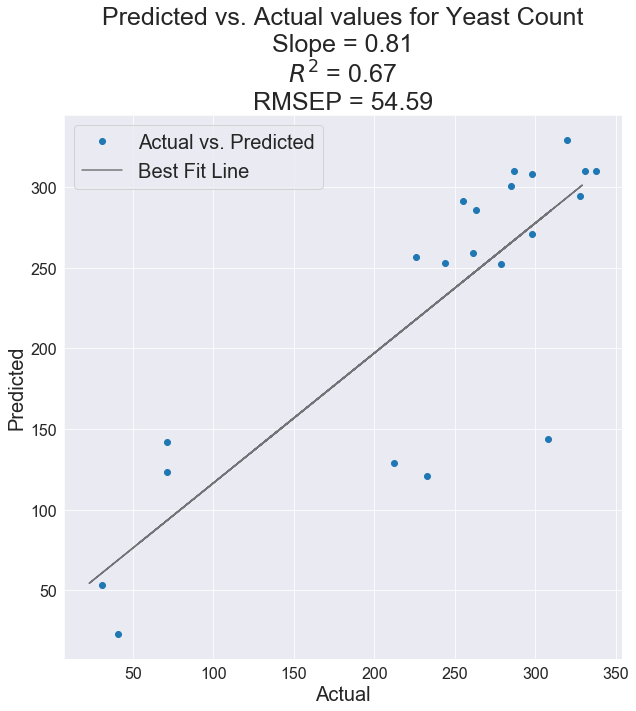

In [172]:
slope,intercept = np.polyfit(testDF[target],pred.reshape(pred.shape[0]),1)
f = np.poly1d([slope,intercept]) 
fig,ax = plt.subplots(figsize = (10,10))
plt.plot(testDF[target],pred,'o', label="Actual vs. Predicted")
plt.plot(pred,f(pred), 'k-',label="Best Fit Line", alpha=0.5)
ax.set_xlabel("Actual", fontsize = 20)
ax.set_ylabel("Predicted", fontsize = 20)
ax.set_title("Predicted vs. Actual values for Yeast Count\nSlope = {}\n$R^2$ = {}\nRMSEP = {}".format(np.round(slope,2),np.round(r2,2), np.round(rmsep,2)), fontsize=25);
ax.legend(prop={"size":20});
for tick in ax.xaxis.get_major_ticks():
    tick.label.set_fontsize(16) 
    
for tick in ax.yaxis.get_major_ticks():
    tick.label.set_fontsize(16) 

# Random Forest

In [176]:
model = RandomForestRegressor(n_estimators=100, max_features='sqrt')
X = dXTrainSpectra
y = trainDF[target]

model.fit(X,y)
pred = model.predict(dXTestSpectra)
r2 = r2_score(y_true=testDF[target], y_pred=pred)
rmsep = np.sqrt(mean_squared_error(y_true=testDF[target], y_pred=pred))
r2, rmsep

(0.7678687077418003, 46.034486543087624)

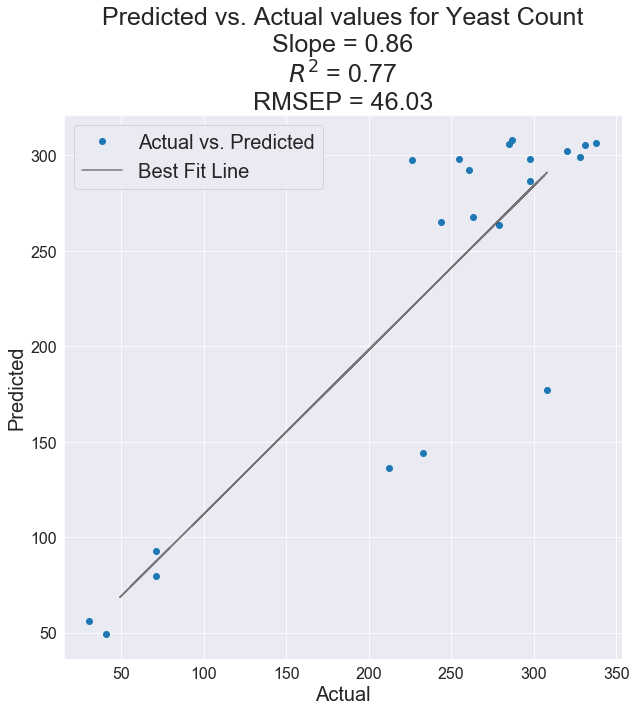

In [177]:
slope,intercept = np.polyfit(testDF[target],pred.reshape(pred.shape[0]),1)
f = np.poly1d([slope,intercept]) 
fig,ax = plt.subplots(figsize = (10,10))
plt.plot(testDF[target],pred,'o', label="Actual vs. Predicted")
plt.plot(pred,f(pred), 'k-',label="Best Fit Line", alpha=0.5)
ax.set_xlabel("Actual", fontsize = 20)
ax.set_ylabel("Predicted", fontsize = 20)
ax.set_title("Predicted vs. Actual values for Yeast Count\nSlope = {}\n$R^2$ = {}\nRMSEP = {}".format(np.round(slope,2),np.round(r2,2), np.round(rmsep,2)), fontsize=25);
ax.legend(prop={"size":20});
for tick in ax.xaxis.get_major_ticks():
    tick.label.set_fontsize(16) 
    
for tick in ax.yaxis.get_major_ticks():
    tick.label.set_fontsize(16) 